<a href="https://colab.research.google.com/github/01Sagar10/Project/blob/main/FS_Customer_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Project
Customer segmentations features

**Category-Specific Spending:** Highlights customer preferences for product categories.

**Data Overview dfps**

Min Date : 01-12-2010

Max Date : 09-12-2011

Unique Customers : 4321

Unique StockCodes : 3673

Unique Countries : 37

Total Sales :  8263941.10

Total Quantity : 4888528

Total Orders : 399248

#Preprocessing

In [76]:
#mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')
import datetime
from datetime import datetime, timedelta
import matplotlib.ticker as ticker
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [78]:
df1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data science projects /Ecommerce customer segmentation/data.csv',
                 encoding='ISO-8859-1') ##'utf-8' codec can't decode byte 0xa3 in position 79780: invalid start byte

In [79]:
formats = ['%m/%d/%Y %H:%M', '%m-%d-%Y %H:%M']

for fmt in formats:
    try:
        df1['InvoiceDate'] = pd.to_datetime(df1['InvoiceDate'], format=fmt, errors = 'coerce') # convert to YYYY-MM-DD HH:MM:SS
        df1['FormattedInvoiceDate'] = df1['InvoiceDate'].dt.strftime('%d-%m-%Y %H:%M:%S')
        if df1['InvoiceDate'].notna().all():
            print(f"Successfully parsed with format: {fmt}")
        break
    except:
        continue

# Check for any remaining NaT values
print(df1['InvoiceDate'].isna().sum())


df1['Day'] = df1['InvoiceDate'].dt.day
df1['Month'] = df1['InvoiceDate'].dt.month
df1['Year'] = df1['InvoiceDate'].dt.year
df1['DayOfWeek'] = df1['InvoiceDate'].dt.dayofweek  # Monday=0, Sunday=6
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df1['DayOfWeek'] = df1['DayOfWeek'].map(dict(enumerate(days)))


reference_date = datetime.now()
df1['Recency'] = (reference_date - df1['InvoiceDate']).dt.days

df1['Hour'] = df1['InvoiceDate'].dt.hour
df1['IsWeekend'] = df1['InvoiceDate'].dt.dayofweek >= 5

df1['Recency']

Successfully parsed with format: %m/%d/%Y %H:%M
0


,Recency
0,5046
1,5046
2,5046
3,5046
4,5046
...,...
541904,4673
541905,4673
541906,4673
541907,4673


In [80]:
df1['TotalSpend'] = df1['Quantity'] * df1['UnitPrice']

In [81]:
tabinfo = pd.DataFrame(df1.dtypes).T.rename(index={0:'column type'}) ## df
tabinfo = pd.concat([tabinfo, pd.DataFrame(df1.isnull().sum()).T.rename(index={0:'null values (nb)'})]) ## nb =
tabinfo = pd.concat([tabinfo, pd.DataFrame(df1.isnull().sum()/df1.shape[0]*100).T.rename(index={0:'null values (%)'})]) ## %
tabinfo = pd.concat([tabinfo, pd.DataFrame(df1.nunique()).T.rename(index={0:'unique values'})])
tabinfo

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,FormattedInvoiceDate,Day,Month,Year,DayOfWeek,Recency,Hour,IsWeekend,TotalSpend
column type,object,object,object,int64,datetime64[ns],float64,float64,object,object,int32,int32,int32,object,int64,int32,bool,float64
null values (nb),0,0,1454,0,0,0,135080,0,0,0,0,0,0,0,0,0,0
null values (%),0.0,0.0,0.268311,0.0,0.0,0.0,24.926694,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
unique values,25900,4070,4223,722,23260,1630,4372,38,23260,31,12,2,6,305,15,2,6204


In [82]:
df1 = df1.dropna(subset=['CustomerID'])


tabinfo = pd.DataFrame(df1.dtypes).T.rename(index={0:'column type'}) ## df
tabinfo = pd.concat([tabinfo, pd.DataFrame(df1.isnull().sum()).T.rename(index={0:'null values (nb)'})]) ## nb =
tabinfo = pd.concat([tabinfo, pd.DataFrame(df1.isnull().sum()/df1.shape[0]*100).T.rename(index={0:'null values (%)'})]) ## %
tabinfo = pd.concat([tabinfo, pd.DataFrame(df1.nunique()).T.rename(index={0:'unique values'})])
tabinfo

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,FormattedInvoiceDate,Day,Month,Year,DayOfWeek,Recency,Hour,IsWeekend,TotalSpend
column type,object,object,object,int64,datetime64[ns],float64,float64,object,object,int32,int32,int32,object,int64,int32,bool,float64
null values (nb),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
null values (%),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
unique values,22190,3684,3896,436,20460,620,4372,37,20460,31,12,2,6,305,15,2,4041


In [83]:
#display all entries that are duplicates except for the first occurrence of each duplicated row

df_dupli = df1[df1.duplicated()].sort_values(by='StockCode', ascending = False)
df_dupli.shape

(5225, 17)

In [84]:
df1[(df1['StockCode'] == "M") & (df1['InvoiceNo'] == "572344" )].sort_values(by = 'InvoiceNo')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,FormattedInvoiceDate,Day,Month,Year,DayOfWeek,Recency,Hour,IsWeekend,TotalSpend
414138,572344,M,Manual,456,2011-10-24 10:43:00,1.5,14607.0,United Kingdom,24-10-2011 10:43:00,24,10,2011,Monday,4719,10,False,684.0
414139,572344,M,Manual,48,2011-10-24 10:43:00,1.5,14607.0,United Kingdom,24-10-2011 10:43:00,24,10,2011,Monday,4719,10,False,72.0
414140,572344,M,Manual,48,2011-10-24 10:43:00,1.5,14607.0,United Kingdom,24-10-2011 10:43:00,24,10,2011,Monday,4719,10,False,72.0
414141,572344,M,Manual,48,2011-10-24 10:43:00,1.5,14607.0,United Kingdom,24-10-2011 10:43:00,24,10,2011,Monday,4719,10,False,72.0
414142,572344,M,Manual,48,2011-10-24 10:43:00,1.5,14607.0,United Kingdom,24-10-2011 10:43:00,24,10,2011,Monday,4719,10,False,72.0
414143,572344,M,Manual,48,2011-10-24 10:43:00,1.5,14607.0,United Kingdom,24-10-2011 10:43:00,24,10,2011,Monday,4719,10,False,72.0
414144,572344,M,Manual,48,2011-10-24 10:43:00,1.5,14607.0,United Kingdom,24-10-2011 10:43:00,24,10,2011,Monday,4719,10,False,72.0


In [85]:
#remove duplicates
print("Total Duplicates",df1.duplicated().sum())
df1.drop_duplicates(inplace=True)

Total Duplicates 5225


___
## 2. Exploring the content of variables

This dataframe contains 8 variables that correspond to:

**InvoiceNo**: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.  <br>
**StockCode**: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product. <br>
**Description**: Product (item) name. Nominal. <br>
**Quantity**: The quantities of each product (item) per transaction. Numeric.	<br>
**InvoiceDate**: Invice Date and time. Numeric, the day and time when each transaction was generated. <br>
**UnitPrice**: Unit price. Numeric, Product price per unit in sterling. <br>
**CustomerID**: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer. <br>
**Country**: Country name. Nominal, the name of the country where each customer resides.<br>
**TotalSpend** Quantity * UnitPrice
___


### Datetime , filter older negative orders
- As data is of fixed time
- anyone with net quantity = 0, has negative orders bigger than Data of given Datasets time range

In [86]:
#rearrange the columns and save the old arrangement as variable
#readability

# Step 1: Save the old column arrangement
old_columns = df1.columns.tolist()

new_columns = ['FormattedInvoiceDate','CustomerID', 'StockCode', 'Description','Quantity', 'UnitPrice', 'TotalSpend', 'InvoiceNo','InvoiceDate', 'Day', 'Month','Year' , 'Recency','DayOfWeek', 'Hour', 'IsWeekend', 'Country' ]

# Step 2: Reorder the columns
df = df1[new_columns]

# Step 3: Save the new column arrangement
new_columns = df.columns.tolist()
df.head()

,FormattedInvoiceDate,CustomerID,StockCode,Description,Quantity,UnitPrice,TotalSpend,InvoiceNo,InvoiceDate,Day,Month,Year,Recency,DayOfWeek,Hour,IsWeekend,Country
0,01-12-2010 08:26:00,17850.0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,15.30,536365,2010-12-01 08:26:00,1,12,2010,5046,Wednesday,8,False,United Kingdom
1,01-12-2010 08:26:00,17850.0,71053,WHITE METAL LANTERN,6,3.39,20.34,536365,2010-12-01 08:26:00,1,12,2010,5046,Wednesday,8,False,United Kingdom
2,01-12-2010 08:26:00,17850.0,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,22.00,536365,2010-12-01 08:26:00,1,12,2010,5046,Wednesday,8,False,United Kingdom
3,01-12-2010 08:26:00,17850.0,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,20.34,536365,2010-12-01 08:26:00,1,12,2010,5046,Wednesday,8,False,United Kingdom
4,01-12-2010 08:26:00,17850.0,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,20.34,536365,2010-12-01 08:26:00,1,12,2010,5046,Wednesday,8,False,United Kingdom


df['CustomerID'] = df['CustomerID'].astype(int)
df_check = df[df['Quantity'] < 0]
print(df_check.shape)
df_check

In [87]:
list_special_codes = df[df['StockCode'].str.contains('^[a-zA-Z]+', regex=True)]['StockCode'].unique()
for code in list_special_codes:
    print("{:<15} -> {:<30}".format(code, df[df['StockCode'] == code]['Description'].unique()[0]))

stockcodes_charges = df[df['StockCode'].isin(list_special_codes)]['StockCode'].unique()
print(stockcodes_charges)

POST            -> POSTAGE                       
D               -> Discount                      
C2              -> CARRIAGE                      
M               -> Manual                        
BANK CHARGES    -> Bank Charges                  
PADS            -> PADS TO MATCH ALL CUSHIONS    
DOT             -> DOTCOM POSTAGE                
CRUK            -> CRUK Commission               
['POST' 'D' 'C2' 'M' 'BANK CHARGES' 'PADS' 'DOT' 'CRUK']


POSTAGE/DOTCOM POSTAGE: The amount spent by the user on postage.

CRUK Commission: An initiative to pay some part of the sales to the Cancer Research UK (CRUK).

Manual: Since there is no proper definition we can think of this as manual service provided for the purchase of an item.

Discount: This explains the discount provided for a product.




In [88]:
#remove all rows where stockcodes_charges matches stockcode except D

df = df[~((df['StockCode'].isin(stockcodes_charges)) & (df['StockCode'] != 'D'))]

list_special_codes = df[df['StockCode'].str.contains('^[a-zA-Z]+', regex=True)]['StockCode'].unique()
for code in list_special_codes:
    print("{:<15} -> {:<30}".format(code, df[df['StockCode'] == code]['Description'].unique()[0]))

#df[df['StockCode']== 'D'].sort_values('Quantity')

D               -> Discount                      


In [89]:
df.shape

(399766, 17)


#Filter negative
We can filter out those negative(means returns) transactions which are before the first positve order

but there like 14 customerIDs where they still have large negative quantities, larger than the sum of quantites from first positive purchase date

Resolved by - removing the customerids whose total Quantity was negative because the data is of a particular range

In [15]:
df.shape

(399766, 17)

In [16]:
df.isnull().sum().sum()

0

In [17]:
df.sort_values(by='CustomerID')[:5]

,FormattedInvoiceDate,CustomerID,StockCode,Description,Quantity,UnitPrice,TotalSpend,InvoiceNo,InvoiceDate,Day,Month,Year,Recency,DayOfWeek,Hour,IsWeekend,Country
61619,18-01-2011 10:01:00,12346.0,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,1.04,77183.60,541431,2011-01-18 10:01:00,18,1,2011,4998,Tuesday,10,False,United Kingdom
61624,18-01-2011 10:17:00,12346.0,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,1.04,-77183.60,C541433,2011-01-18 10:17:00,18,1,2011,4998,Tuesday,10,False,United Kingdom
286629,02-08-2011 08:48:00,12347.0,20719,WOODLAND CHARLOTTE BAG,10,0.85,8.50,562032,2011-08-02 08:48:00,2,8,2011,4802,Tuesday,8,False,Iceland
148299,07-04-2011 10:43:00,12347.0,21041,RED RETROSPOT OVEN GLOVE DOUBLE,6,2.95,17.70,549222,2011-04-07 10:43:00,7,4,2011,4919,Thursday,10,False,Iceland
148300,07-04-2011 10:43:00,12347.0,22423,REGENCY CAKESTAND 3 TIER,3,12.75,38.25,549222,2011-04-07 10:43:00,7,4,2011,4919,Thursday,10,False,Iceland


In [18]:
#df[(df['CustomerID'] == 17850) & (df['StockCode'] == '21730')]

In [19]:
df[(df['CustomerID'] == 17850) & (df['StockCode'] == '21730')]

,FormattedInvoiceDate,CustomerID,StockCode,Description,Quantity,UnitPrice,TotalSpend,InvoiceNo,InvoiceDate,Day,Month,Year,Recency,DayOfWeek,Hour,IsWeekend,Country
6,01-12-2010 08:26:00,17850.0,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,4.25,25.50,536365,2010-12-01 08:26:00,1,12,2010,5046,Wednesday,8,False,United Kingdom
64,01-12-2010 09:02:00,17850.0,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,4.25,25.50,536373,2010-12-01 09:02:00,1,12,2010,5046,Wednesday,9,False,United Kingdom
81,01-12-2010 09:32:00,17850.0,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,4.25,25.50,536375,2010-12-01 09:32:00,1,12,2010,5046,Wednesday,9,False,United Kingdom
295,01-12-2010 10:51:00,17850.0,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,4.25,25.50,536396,2010-12-01 10:51:00,1,12,2010,5046,Wednesday,10,False,United Kingdom
432,01-12-2010 11:33:00,17850.0,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,4.25,25.50,536406,2010-12-01 11:33:00,1,12,2010,5046,Wednesday,11,False,United Kingdom
3129,02-12-2010 08:32:00,17850.0,21730,GLASS STAR FROSTED T-LIGHT HOLDER,4,4.25,17.00,536600,2010-12-02 08:32:00,2,12,2010,5045,Thursday,8,False,United Kingdom
3140,02-12-2010 08:34:00,17850.0,21730,GLASS STAR FROSTED T-LIGHT HOLDER,4,4.25,17.00,536602,2010-12-02 08:34:00,2,12,2010,5045,Thursday,8,False,United Kingdom
3207,02-12-2010 09:41:00,17850.0,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,4.25,25.50,536609,2010-12-02 09:41:00,2,12,2010,5045,Thursday,9,False,United Kingdom
3238,02-12-2010 09:44:00,17850.0,21730,GLASS STAR FROSTED T-LIGHT HOLDER,4,4.25,17.00,536612,2010-12-02 09:44:00,2,12,2010,5045,Thursday,9,False,United Kingdom
3440,02-12-2010 10:54:00,17850.0,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,4.25,25.50,536628,2010-12-02 10:54:00,2,12,2010,5045,Thursday,10,False,United Kingdom


In [20]:
#For each CustomerID and StockCode, calculate the total quantity purchased and the total quantity returned.

#Calculate Net Quantity: Subtract the total quantity returned from the total quantity purchased to get the net quantity. If the net quantity is greater than zero, keep those items in the DataFrame.
"""
summary = df.groupby(['CustomerID', 'StockCode']).agg(
    total_purchased=('Quantity', lambda x: x[x > 0].sum()), #For each value x in a series or DataFrame, keep only the values that are greater than 0 and then add them
    total_returned=('Quantity', lambda x: x[x < 0].sum())
).reset_index()


# Apply .abs() after the aggregation
summary['total_returned'] = summary['total_returned'].abs()

summary['NetQuantity'] = summary['total_purchased'] - summary['total_returned']
#summary = summary[summary['NetQuantity'] > 0] #If the net quantity is greater than zero, keep those items in the DataFrame
summary"""

"\nsummary = df.groupby(['CustomerID', 'StockCode']).agg(\n    total_purchased=('Quantity', lambda x: x[x > 0].sum()), #For each value x in a series or DataFrame, keep only the values that are greater than 0 and then add them\n    total_returned=('Quantity', lambda x: x[x < 0].sum())\n).reset_index()\n\n\n# Apply .abs() after the aggregation\nsummary['total_returned'] = summary['total_returned'].abs()\n\nsummary['NetQuantity'] = summary['total_purchased'] - summary['total_returned']\n#summary = summary[summary['NetQuantity'] > 0] #If the net quantity is greater than zero, keep those items in the DataFrame\nsummary"

In [21]:
#summary[(summary['CustomerID'] == 17850) & (summary['StockCode'] == '21730')]

In [22]:
test = df[(df['CustomerID'] == 17850) & (df['StockCode'] == '21730')]
total_returned = test['Quantity'][test['Quantity'] < 0].sum()
print(total_returned)

-2


In [23]:
#categorising purchased and returned
#df_purchased = df[df['Quantity'] > 0]
#df_returned = df[df['Quantity'] < 0]

In [24]:
##checking data
#df_returned[(df_returned['CustomerID'] == 17850) & (df_returned['StockCode'] == '21730')]

In [25]:
df[df['CustomerID'] == 17850]['TotalSpend'].sum()

5303.4800000000005

In [26]:
# Step 1: Find customers with less than or equal to 0  quantities
#customers_with_negative_spend = df[df['TotalSpend'] < 0]['CustomerID'].unique()
customer_with_negative_spend = df.groupby('CustomerID')['Quantity'].sum() <= 0
customers_with_negative_spend = customer_with_negative_spend[customer_with_negative_spend].index

In [27]:
customer_with_negative_spend

,Quantity
CustomerID,
12346.0,True
12347.0,False
12348.0,False
12349.0,False
12350.0,False
...,...
18280.0,False
18281.0,False
18282.0,False


In [28]:
# Step 2: Filter out these customers from the original DataFrame
df_positive_spend = df[~df['CustomerID'].isin(customers_with_negative_spend)]#.sort_values# "~" opposite of function written

In [29]:
df_positive_spend.shape

(399248, 17)

In [30]:
dfps = df_positive_spend.copy()

In [31]:
dfps['CustomerID'].nunique()

4321

In [32]:
df['CustomerID'].nunique()

4363

In [33]:
df1.shape

(401604, 17)

In [34]:
df.shape #multile transactions of 30 customerIDs removed

(399766, 17)

In [35]:
df[df['TotalSpend']>0].groupby('CustomerID')['InvoiceDate'].min().sort_values(ascending=True)

,InvoiceDate
CustomerID,
17850.0,2010-12-01 08:26:00
13047.0,2010-12-01 08:34:00
12583.0,2010-12-01 08:45:00
13748.0,2010-12-01 09:00:00
15100.0,2010-12-01 09:09:00
...,...
13436.0,2011-12-08 10:33:00
15520.0,2011-12-08 10:58:00
13298.0,2011-12-08 13:11:00


In [36]:
df.sort_values(by='CustomerID')

,FormattedInvoiceDate,CustomerID,StockCode,Description,Quantity,UnitPrice,TotalSpend,InvoiceNo,InvoiceDate,Day,Month,Year,Recency,DayOfWeek,Hour,IsWeekend,Country
61619,18-01-2011 10:01:00,12346.0,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,1.04,77183.60,541431,2011-01-18 10:01:00,18,1,2011,4998,Tuesday,10,False,United Kingdom
61624,18-01-2011 10:17:00,12346.0,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,1.04,-77183.60,C541433,2011-01-18 10:17:00,18,1,2011,4998,Tuesday,10,False,United Kingdom
286629,02-08-2011 08:48:00,12347.0,20719,WOODLAND CHARLOTTE BAG,10,0.85,8.50,562032,2011-08-02 08:48:00,2,8,2011,4802,Tuesday,8,False,Iceland
148299,07-04-2011 10:43:00,12347.0,21041,RED RETROSPOT OVEN GLOVE DOUBLE,6,2.95,17.70,549222,2011-04-07 10:43:00,7,4,2011,4919,Thursday,10,False,Iceland
148300,07-04-2011 10:43:00,12347.0,22423,REGENCY CAKESTAND 3 TIER,3,12.75,38.25,549222,2011-04-07 10:43:00,7,4,2011,4919,Thursday,10,False,Iceland
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
392742,12-10-2011 10:23:00,18287.0,72349B,SET/6 PURPLE BUTTERFLY T-LIGHTS,48,1.69,81.12,570715,2011-10-12 10:23:00,12,10,2011,4731,Wednesday,10,False,United Kingdom
392741,12-10-2011 10:23:00,18287.0,72351A,SET/6 TURQUOISE BUTTERFLY T-LIGHTS,24,2.10,50.40,570715,2011-10-12 10:23:00,12,10,2011,4731,Wednesday,10,False,United Kingdom
392740,12-10-2011 10:23:00,18287.0,72351B,SET/6 PINK BUTTERFLY T-LIGHTS,24,2.10,50.40,570715,2011-10-12 10:23:00,12,10,2011,4731,Wednesday,10,False,United Kingdom
392731,12-10-2011 10:23:00,18287.0,35967,FOLK ART METAL STAR T-LIGHT HOLDER,36,0.38,13.68,570715,2011-10-12 10:23:00,12,10,2011,4731,Wednesday,10,False,United Kingdom


#Data Overview

In [37]:
df

,FormattedInvoiceDate,CustomerID,StockCode,Description,Quantity,UnitPrice,TotalSpend,InvoiceNo,InvoiceDate,Day,Month,Year,Recency,DayOfWeek,Hour,IsWeekend,Country
0,01-12-2010 08:26:00,17850.0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,15.30,536365,2010-12-01 08:26:00,1,12,2010,5046,Wednesday,8,False,United Kingdom
1,01-12-2010 08:26:00,17850.0,71053,WHITE METAL LANTERN,6,3.39,20.34,536365,2010-12-01 08:26:00,1,12,2010,5046,Wednesday,8,False,United Kingdom
2,01-12-2010 08:26:00,17850.0,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,22.00,536365,2010-12-01 08:26:00,1,12,2010,5046,Wednesday,8,False,United Kingdom
3,01-12-2010 08:26:00,17850.0,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,20.34,536365,2010-12-01 08:26:00,1,12,2010,5046,Wednesday,8,False,United Kingdom
4,01-12-2010 08:26:00,17850.0,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,20.34,536365,2010-12-01 08:26:00,1,12,2010,5046,Wednesday,8,False,United Kingdom
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
541904,09-12-2011 12:50:00,12680.0,22613,PACK OF 20 SPACEBOY NAPKINS,12,0.85,10.20,581587,2011-12-09 12:50:00,9,12,2011,4673,Friday,12,False,France
541905,09-12-2011 12:50:00,12680.0,22899,CHILDREN'S APRON DOLLY GIRL,6,2.10,12.60,581587,2011-12-09 12:50:00,9,12,2011,4673,Friday,12,False,France
541906,09-12-2011 12:50:00,12680.0,23254,CHILDRENS CUTLERY DOLLY GIRL,4,4.15,16.60,581587,2011-12-09 12:50:00,9,12,2011,4673,Friday,12,False,France
541907,09-12-2011 12:50:00,12680.0,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,4.15,16.60,581587,2011-12-09 12:50:00,9,12,2011,4673,Friday,12,False,France


In [38]:
#dfps = filtered df
#df = unfiltered
def Overview(df,InvoiceDate, CustomerID, StockCode, Country, TotalSpend, Quantity, InvoiceNo ):
  #df[['TotalSpend','Quantity','InvoiceDate', 'UnitPrice']].describe()
  maxdate = df['InvoiceDate'].max().strftime('%d-%m-%Y')
  mindate = df['InvoiceDate'].min().strftime('%d-%m-%Y')
  unique_cust = df['CustomerID'].nunique()
  unique_stock = df['StockCode'].nunique()
  unique_country = df['Country'].nunique()
  total_sales = df['TotalSpend'].sum()
  total_qty = df['Quantity'].sum()
  total_orders = df['InvoiceNo'].count()

  print(f'Min Date : {mindate}')
  print(f'Max Date : {maxdate}')
  print(f'Unique Customers : {unique_cust}')
  print(f'Unique StockCodes : {unique_stock}')
  print(f'Unique Countries : {unique_country}')
  print(f'Total Sales : {total_sales: .2f}')
  print(f'Total Quantity : {total_qty}')
  print(f'Total Orders : {total_orders}')

  return

Overview(dfps, 'InvoiceDate', 'CustomerID', 'StockCode', 'Country', 'TotalSpend', 'Quantity', 'InvoiceNo')

Min Date : 01-12-2010
Max Date : 09-12-2011
Unique Customers : 4321
Unique StockCodes : 3673
Unique Countries : 37
Total Sales :  8263941.10
Total Quantity : 4888528
Total Orders : 399248


#RFM by CustomerID and Scorings
Recency: Latest date-Last invoice date. (Number of days since the last purchase date)
Frequency: Count of invoice numbers. (Total number of transactions made by a unique customer)
Monetary: Sum of Total sales. (Total value of transacted sales by each customer)

In [39]:
dfps.sort_values(by='InvoiceDate', ascending = False)

,FormattedInvoiceDate,CustomerID,StockCode,Description,Quantity,UnitPrice,TotalSpend,InvoiceNo,InvoiceDate,Day,Month,Year,Recency,DayOfWeek,Hour,IsWeekend,Country
541908,09-12-2011 12:50:00,12680.0,22138,BAKING SET 9 PIECE RETROSPOT,3,4.95,14.85,581587,2011-12-09 12:50:00,9,12,2011,4673,Friday,12,False,France
541901,09-12-2011 12:50:00,12680.0,22367,CHILDRENS APRON SPACEBOY DESIGN,8,1.95,15.60,581587,2011-12-09 12:50:00,9,12,2011,4673,Friday,12,False,France
541895,09-12-2011 12:50:00,12680.0,22556,PLASTERS IN TIN CIRCUS PARADE,12,1.65,19.80,581587,2011-12-09 12:50:00,9,12,2011,4673,Friday,12,False,France
541896,09-12-2011 12:50:00,12680.0,22555,PLASTERS IN TIN STRONGMAN,12,1.65,19.80,581587,2011-12-09 12:50:00,9,12,2011,4673,Friday,12,False,France
541897,09-12-2011 12:50:00,12680.0,22728,ALARM CLOCK BAKELIKE PINK,4,3.75,15.00,581587,2011-12-09 12:50:00,9,12,2011,4673,Friday,12,False,France
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3,01-12-2010 08:26:00,17850.0,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,20.34,536365,2010-12-01 08:26:00,1,12,2010,5046,Wednesday,8,False,United Kingdom
1,01-12-2010 08:26:00,17850.0,71053,WHITE METAL LANTERN,6,3.39,20.34,536365,2010-12-01 08:26:00,1,12,2010,5046,Wednesday,8,False,United Kingdom
5,01-12-2010 08:26:00,17850.0,22752,SET 7 BABUSHKA NESTING BOXES,2,7.65,15.30,536365,2010-12-01 08:26:00,1,12,2010,5046,Wednesday,8,False,United Kingdom
6,01-12-2010 08:26:00,17850.0,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,4.25,25.50,536365,2010-12-01 08:26:00,1,12,2010,5046,Wednesday,8,False,United Kingdom


In [40]:
len1 = dfps.groupby('CustomerID').agg({'InvoiceNo' : lambda x : len(x)})
len1

,InvoiceNo
CustomerID,
12347.0,182
12348.0,27
12349.0,72
12350.0,16
12352.0,84
...,...
18280.0,10
18281.0,7
18282.0,13


In [41]:
len2 = dfps.groupby('CustomerID').agg({'InvoiceNo' : 'count'})
len2

,InvoiceNo
CustomerID,
12347.0,182
12348.0,27
12349.0,72
12350.0,16
12352.0,84
...,...
18280.0,10
18281.0,7
18282.0,13


In [42]:
latest = dfps['InvoiceDate'].max() + timedelta(1)

def RFM(df, CustomerID, InvoiceDate, InvoiceNo, TotalSpend):
  #or RFM_scores = dfps.groupby('CustomerID).agg({'InvoiceDate': lambda x : (latest - x.max()).days, 'InvoiceNo': lambda x : len(x), 'TotalSpend' :lambda x : x.sum()})

  RFM_scores = df.groupby('CustomerID').agg({ 'InvoiceDate' : lambda x : (latest - x.max()).days,
                                                 'InvoiceNo' : lambda x : len(x),
                                                 'TotalSpend' : lambda x : x.sum()})
  RFM_scores.rename(columns = {'InvoiceDate' : 'Recency',
                               'InvoiceNo' : 'Frequency',
                               'TotalSpend' : 'Monetary'}, inplace = True)
  return RFM_scores.sort_values(by = 'CustomerID' , ascending = True).reset_index()

RFM_values = RFM(dfps, 'CustomerID', 'InvoiceDate', 'InvoiceNo', 'TotalSpend')
RFM_values

,CustomerID,Recency,Frequency,Monetary
0,12347.0,2,182,4310.00
1,12348.0,75,27,1437.24
2,12349.0,19,72,1457.55
3,12350.0,310,16,294.40
4,12352.0,36,84,1265.41
...,...,...,...,...
4316,18280.0,278,10,180.60
4317,18281.0,181,7,80.82
4318,18282.0,8,13,176.60
4319,18283.0,4,719,2039.58


In [43]:
# RFM_values['R'], binsR = pd.qcut(RFM_values['Recency'], q=5, labels=False, retbins=True, duplicates='drop')

# print('RFM_values_country :',RFM_values['R'].to_list())
# print('binsR :',binsR)  #[ ]

# print('range(len(RFM_values_country[Recency].unique())) [::-1]: ', range(len(RFM_values['R'].unique()))[::-1]) # range of ( Max , till -1, with step -1)
# """
# if range of len is (0, 4), reversing the range becomes ( 4, exluding -1, with step -1) viz 4,3,2,1
# """
# labelsR = [f'{i+1}' for i in range(len(RFM_values['R'].unique()))][::-1]
# print('labelR :', labelsR)

# """
# # reversing the range() and adding 1, becomes 5,4,3,2,1

# """
# unique_vals = sorted(RFM_values['R'].unique())  # Sort unique values to map labels correctly
# print('unique_vals : ',unique_vals)

# """
# sorting  ascending uniques from R which is (0,1,2,3,4)

# """
# label_to_int_R = {val: labelsR[idx] for idx, val in enumerate(unique_vals)}
# print('label_to int_R :',label_to_int_R)


# # LabelsR[idx] accesses the corresponding element in the labelsR list based on the index (idx).
# # idx in enumerate is 0, 1,2,3,4
# # val in enumerate is 0,1,2,3,4 (from unique_vals = [0, 1, 2, 3, 4]).

# # idx = 0, val = 0 (from unique_vals = [0, 1, 2, 3, 4]).
# # labelsR[0] = '5'.
# # Mapping = 0 : '5'

# # idx = 2, val = 2.
# # labelsR[2] = '3'.
# # Mapping: 2: '3'.

# RFM_values['R'] = RFM_values['R'].map(label_to_int_R)

# print("Mapped values", RFM_values['R'].to_dict())


# """
# wherever there is any 0/1/2/3/4 values in ['R']
# it will become '5'/'4'/'3'/'2'/'1' respectively.

# """


# RFM_values['F'], bins = pd.qcut(RFM_values['Frequency'], q=5, labels=False, retbins=True, duplicates='drop')
# print('\n ','RFM_values_country[''F'']', RFM_values['F'].to_list())
# print('bins :',bins)
# print('range(len(RFM_values_country[Frequency].unique())', range(len(RFM_values['F'].unique())))

# labelsF = [f'{i+1}' for i in range(len(RFM_values['F'].unique()))]
# print('labelsF', labelsF)

# labels_to_int_F = {i:j+1 for j, i in enumerate(range(len(labelsF)))}
# print('labels_to_intF', labels_to_int_F)

# RFM_values['F'] = RFM_values['F'].map(labels_to_int_F)
# print(RFM_values['F'])

In [44]:
def RFM_score(df, Recency, Frequency, Monetary):
    df['R'], binsR = pd.qcut(df[Recency], q=5, labels=False, retbins=True, duplicates='drop')
    # Create reversed labels
    labelsR = [f'{i+1}' for i in range(len(df['R'].unique()))][::-1]  # Reverse the list
    # Map original quantiles to the reversed labels
    unique_vals = sorted(df['R'].unique())  # Sort unique values to map labels correctly
    label_to_int_R = {val: labelsR[idx] for idx, val in enumerate(unique_vals)}

    # Apply the mapping to Recency column
    df['R'] = df['R'].map(label_to_int_R)

    # For Frequency
    df['F'], binsF = pd.qcut(df[Frequency], q=5, labels=False, retbins=True, duplicates='drop')
    labelsF = [f'{i+1}' for i in range(len(df['F'].unique()))] #returns string outputs
    label_to_int_F = {i: j+1 for j, i in enumerate(range(len(labelsF)))}
    df['F'] = df['F'].map(label_to_int_F)

    # For Monetary
    df['M'], binsM = pd.qcut(df[Monetary], q=5, labels=False, retbins=True, duplicates='drop')
    labelsM = [f'{i+1}' for i in range(len(df['M'].unique()))]
    label_to_int_M = {i: j+1 for j, i in enumerate(range(len(labelsM)))}
    df['M'] = df['M'].map(label_to_int_M)

    df['R'].fillna(0, inplace=True)
    df['F'].fillna(0, inplace=True)
    df['M'].fillna(0, inplace=True)

    # Check for NaN values in the mapped columns
    print("NaN values in 'R':", df['R'].isna().sum())
    print("NaN values in 'F':", df['F'].isna().sum())
    print("NaN values in 'M':", df['M'].isna().sum())

    # Calculate additional columns and final score
    df['RFM'] = df['R'].astype(str) + df['F'].astype(str) + df['M'].astype(str)
    df['Score'] = df['R'].astype(int) + df['F'].astype(int) + df['M'].astype(int)

    return df

RFMscore_df = RFM_score(RFM_values, 'Recency', 'Frequency', 'Monetary')
RFMscore_df

NaN values in 'R': 0
NaN values in 'F': 0
NaN values in 'M': 0


,CustomerID,Recency,Frequency,Monetary,R,F,M,RFM,Score
0,12347.0,2,182,4310.00,5,5,5,555,15
1,12348.0,75,27,1437.24,2,2,4,224,8
2,12349.0,19,72,1457.55,4,4,4,444,12
3,12350.0,310,16,294.40,1,2,2,122,5
4,12352.0,36,84,1265.41,3,4,4,344,11
...,...,...,...,...,...,...,...,...,...
4316,18280.0,278,10,180.60,1,1,1,111,3
4317,18281.0,181,7,80.82,1,1,1,111,3
4318,18282.0,8,13,176.60,5,1,1,511,7
4319,18283.0,4,719,2039.58,5,5,5,555,15


In [45]:
RFMscore_df['R'].unique()

array(['5', '2', '4', '1', '3'], dtype=object)

In [46]:
# RFM_values['M'], binsM = pd.qcut(RFM_values['Monetary'], q=5, labels=False, retbins=True, duplicates='drop')
# labelsM = [f'{i+1}' for i in range(len(RFM_values['M'].unique()))]

# print('RFM_vales[''M'']', RFM_values['M'].to_list())

# print('\nUnique LabelsM str', labelsM)
# print('\ndict(enumerate(labelsM)) str', dict(enumerate(labelsM)))

# RFM_values['M'] = RFM_values['M'].map(dict(enumerate(labelsM)))
# print('\nRFM_vales[''M''] str', RFM_values['M'].to_list())


# RFM_values['M'], binsM = pd.qcut(RFM_values['Monetary'], q=5, labels=False, retbins=True, duplicates='drop')
# labelsM = [f'{i+1}' for i in range(len(RFM_values['M'].unique()))]

# label_to_int_M = {i: j+1 for j, i in enumerate(range(len(labelsM)))}
# print('\nUnique LabelsM int', labelsM)
# print('\n dictenumerate label_to_int_M int', dict(enumerate(label_to_int_M)))

# RFM_values['M'] = RFM_values['M'].map(label_to_int_M)
# print('RFM_vales[''M''] int', RFM_values['M'].to_list())

# RFM_values['RFM'] = RFM_values['R'].astype(str) + RFM_values['F'].astype(str) + RFM_values['M'].astype(str)
# #df['Score'] = RFM_values['R'].astype(int) + RFM_values['F'].astype(int) + RFM_values['M'].astype(int)

In [47]:
# RFMscore_df['Loyalty'], bins = pd.qcut(RFMscore_df['Score'], q = 4, labels = False, duplicates = 'drop', retbins = True)
# unique_labels = [f'Loyal{i+1}' for i  in range(len(RFMscore_df['Loyalty'].unique()))]
# print('Unique_labels', unique_labels)
# print('df[''loyalty'']', RFMscore_df['Loyalty'].to_list())
# print('dict(enumerate(unique_labels)', dict(enumerate(unique_labels)))
# RFMscore_df['Loyalty'] = RFMscore_df['Loyalty'].map(dict(enumerate(unique_labels)))
# print('df[''loyalty'']', RFMscore_df['Loyalty'].to_list())

In [48]:
# distribute the score f RFMscore_df['Score'] into 4 quantiles

def Loyaltyscore(df, Recency, Frequency, Monetary, Score):
    num_bins = 4

    # Check if there is only one customer
    if df['CustomerID'].nunique() == 1:
        # If only one customer, assign the entire group to a single loyalty label
        df['Loyalty'] = 'Loyal1'
    else:
        # Quantile distribution, duplicates dropped, retbins to get bins
        df['Loyalty'], bins = pd.qcut(df[Score], q=num_bins, labels=False, duplicates='drop', retbins=True)

        unique_labels = [f'Loyal{i+1}' for i in range(len(df['Loyalty'].unique()))]

        df['Loyalty'] = df['Loyalty'].map(dict(enumerate(unique_labels)))

    # Return the mean values grouped by Loyalty
    return df.groupby('Loyalty').agg({Recency: 'mean', Frequency: 'mean', Monetary: 'mean'})

# Call the function
Loyaltyscore(RFMscore_df, 'Recency', 'Frequency', 'Monetary', 'Score')


,Recency,Frequency,Monetary
Loyalty,,,
Loyal1,187.121517,14.896285,254.048421
Loyal2,85.028285,37.297445,699.976204
Loyal3,43.719524,85.116947,1398.282993
Loyal4,13.809524,274.070346,6231.243593


###changing weights RFM analysis

In [49]:
def ChangeWeightsScore(df, Recency, Frequency, Monetary):
    # Custom labels for quantiles (adjusted for business needs)

     # For Recency
    df['R'], binsR = pd.qcut(df[Recency], q=5, labels=False, retbins=True, duplicates='drop')
    # Create reversed labels
    labelsR = [f'{i+1}' for i in range(len(df['R'].unique()))][::-1]  # Reverse the list
    # Map original quantiles to the reversed labels
    unique_vals = sorted(df['R'].unique())  # Sort unique values to map labels correctly
    label_to_int_R = {val: labelsR[idx] for idx, val in enumerate(unique_vals)}

    # Apply the mapping to Recency column
    df['R'] = df['R'].map(label_to_int_R)

    # For Frequency
    df['F'], binsF = pd.qcut(df[Frequency], q=3, labels=False, retbins=True, duplicates='drop')
    labelsF = [f'{i+1}' for i in range(len(df['F'].unique()))]
    label_to_int_F = {i: j+1 for j, i in enumerate(range(len(labelsF)))}
    df['F'] = df['F'].map(label_to_int_F)

    # For Monetary
    df['M'], binsM = pd.qcut(df[Monetary], q=5, labels=False, retbins=True, duplicates='drop')
    labelsM = [f'{i+1}' for i in range(len(df['M'].unique()))]
    label_to_int_M = {i: j+1 for j, i in enumerate(range(len(labelsM)))}
    df['M'] = df['M'].map(label_to_int_M)

    df['R'].fillna(0, inplace=True)
    df['F'].fillna(0, inplace=True)
    df['M'].fillna(0, inplace=True)

    # Check for NaN values in the mapped columns
    print("NaN values in 'R':", df['R'].isna().sum())
    print("NaN values in 'F':", df['F'].isna().sum())
    print("NaN values in 'M':", df['M'].isna().sum())

    # Calculate additional columns and final score
    df['RFM'] = df['R'].astype(str) + df['F'].astype(str) + df['M'].astype(str)
    df['Score'] = df['R'].astype(int) + df['F'].astype(int) + df['M'].astype(int)

    df['R_weighted'] = df['R'].fillna(0).astype(int) * 0.5
    df['F_weighted'] = df['F'].fillna(0).astype(int) * 0.3
    df['M_weighted'] = df['M'].fillna(0).astype(int) * 0.5

    # Exponentially scale Recency and Monetary
    df['R_weighted_exp'] = 2 ** (df['R_weighted'].astype(float))
    df['M_weighted_exp'] = 2 ** (df['M_weighted'].astype(float))

    # Final score calculation
    df['ExpWeightedScore'] = df['R_weighted_exp'] + df['F_weighted'] + df['M_weighted_exp']

    return df

# Example usage
WeightedRFMscore_df = ChangeWeightsScore(RFM_values, 'Recency', 'Frequency', 'Monetary')
WeightedRFMscore_df

NaN values in 'R': 0
NaN values in 'F': 0
NaN values in 'M': 0


,CustomerID,Recency,Frequency,Monetary,R,F,M,RFM,Score,Loyalty,R_weighted,F_weighted,M_weighted,R_weighted_exp,M_weighted_exp,ExpWeightedScore
0,12347.0,2,182,4310.00,5,3,5,535,13,Loyal4,2.5,0.9,2.5,5.656854,5.656854,12.213708
1,12348.0,75,27,1437.24,2,2,4,224,8,Loyal2,1.0,0.6,2.0,2.000000,4.000000,6.600000
2,12349.0,19,72,1457.55,4,2,4,424,10,Loyal3,2.0,0.6,2.0,4.000000,4.000000,8.600000
3,12350.0,310,16,294.40,1,1,2,112,4,Loyal1,0.5,0.3,1.0,1.414214,2.000000,3.714214
4,12352.0,36,84,1265.41,3,3,4,334,10,Loyal3,1.5,0.9,2.0,2.828427,4.000000,7.728427
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4316,18280.0,278,10,180.60,1,1,1,111,3,Loyal1,0.5,0.3,0.5,1.414214,1.414214,3.128427
4317,18281.0,181,7,80.82,1,1,1,111,3,Loyal1,0.5,0.3,0.5,1.414214,1.414214,3.128427
4318,18282.0,8,13,176.60,5,1,1,511,7,Loyal2,2.5,0.3,0.5,5.656854,1.414214,7.371068
4319,18283.0,4,719,2039.58,5,3,5,535,13,Loyal4,2.5,0.9,2.5,5.656854,5.656854,12.213708


In [50]:
def CWLoyaltyScore(df, Recency, Frequency, Monetary, ExpWeightedScore):
    # Define the number of quantiles (bins)
    num_bins = 8

     # Ensure Weightedloyalty_df is defined in all cases
    Weightedloyalty_df = None

    if df['CustomerID'].nunique() == 1:
        df['ExpWeightedScore_Q'] = 'Loyal1'
    else:
      # Calculate quantiles based on the exponential weighted score
      df['ExpWeightedScore_Q'], bins = pd.qcut(df[ExpWeightedScore], q=num_bins, labels=False, retbins=True, duplicates='drop') #returns the bin edges for further reference.

      # Define labels manually, ensuring they match the number of unique bins after duplicates are dropped
      unique_labels = [f'Loyal{i+1}' for i in range(len(df['ExpWeightedScore_Q'].unique()))]

      # Map the quantile bin numbers to labels
      df['ExpWeightedScore_Q'] = df['ExpWeightedScore_Q'].map(dict(enumerate(unique_labels)))

      # Calculate mean values for each group based on the generated labels
    return df.groupby('ExpWeightedScore_Q').agg({Recency: 'mean', Frequency: 'mean', Monetary: 'mean'})

# Example usage
# Assuming WeightedRFMscore_df is your DataFrame with the appropriate columns
CWLoyaltyScore(WeightedRFMscore_df, 'Recency', 'Frequency', 'Monetary', 'ExpWeightedScore')


,Recency,Frequency,Monetary
ExpWeightedScore_Q,,,
Loyal1,241.137784,12.845170,195.156193
Loyal2,145.964646,21.777778,297.798914
Loyal3,111.488616,35.901926,497.196375
Loyal4,71.270541,46.669339,606.138236
Loyal5,51.020864,72.302534,1074.651744
Loyal6,34.265010,81.157350,1526.106542
Loyal7,20.381910,177.227806,3320.112965
Loyal8,5.212500,360.685000,9954.881100


#Quantile of CustomerID's total spendings (CLV)
Each Qualtile showing total_spendings from Highest to Lowest

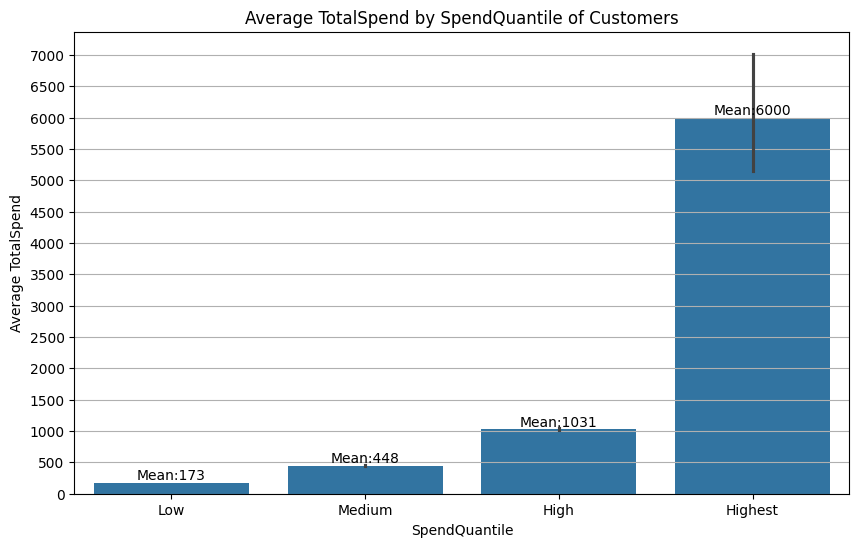

HighestSpend Customers 
 1682    14646.0
Name: CustomerID, dtype: float64 
 HighSpend Customers 
 0       12347.0
8       12356.0
9       12357.0
11      12359.0
12      12360.0
         ...   
4303    18259.0
4304    18260.0
4311    18272.0
4319    18283.0
4320    18287.0
Name: CustomerID, Length: 1080, dtype: float64 
 MediumSpend Customers 
 1       12348.0
2       12349.0
4       12352.0
6       12354.0
10      12358.0
         ...   
4289    18237.0
4290    18239.0
4296    18248.0
4307    18263.0
4308    18265.0
Name: CustomerID, Length: 1080, dtype: float64 
 LowSpend Customers 
 3       12350.0
5       12353.0
7       12355.0
13      12361.0
15      12363.0
         ...   
4314    18277.0
4315    18278.0
4316    18280.0
4317    18281.0
4318    18282.0
Name: CustomerID, Length: 2160, dtype: float64


In [ ]:
def CustSpendQuantile( df, CustomerID, TotalSpend, quantiles = 4, interval = 500):

  df_CLV = df.groupby('CustomerID')['TotalSpend'].sum().reset_index()
  df_CLV['TotalSpend'].fillna(0, inplace=True)

  labels = ['Low', 'Medium', 'High', 'Highest']
   # Calculate quantiles and handle cases with fewer than 'quantiles' unique quantiles
  bins = pd.qcut(df_CLV['TotalSpend'], q = quantiles, labels = False, retbins = True, duplicates = 'drop')[1]
  num_bins = len(bins) - 1

  if num_bins < quantiles:
    print(f"Warning: Not enough data to create {quantiles} quantiles. Reducing to {num_bins}.")
    quantiles = num_bins
    labels = labels[:num_bins] # Adjust labels to match reduced quantiles
    bins = bins[:num_bins + 1]  # Adjust bins to match reduced quantiles


  # Adjust bin access, SpendQuantile assignment, and labels based on the number of bins
  if num_bins > 0: # changed condition check based on the warning implementation
      # Use custom labels if available, otherwise use numerical labels
      df_CLV['SpendQuantile'] = pd.cut(df_CLV['TotalSpend'], bins=bins,
                                      labels=labels if num_bins <= len(labels) else False,
                                      include_lowest=True, duplicates='drop')

       #Access segments based on quantiles, handling potential IndexError
      df_CLV_highest = df_CLV[df_CLV['TotalSpend'] >= bins[-1]].get('CustomerID') if num_bins > 0 else pd.Series([], dtype=object)
      df_CLV_high = df_CLV[(df_CLV['TotalSpend'] < bins[-1]) & (df_CLV['TotalSpend'] >= bins[-2])].get('CustomerID') if num_bins > 1 else pd.Series([], dtype=object)
      df_CLV_medium = df_CLV[(df_CLV['TotalSpend'] < bins[-2]) & (df_CLV['TotalSpend']>= bins[-3])].get('CustomerID') if num_bins > 2 else pd.Series([], dtype=object)
      df_CLV_low = df_CLV[(df_CLV['TotalSpend'] < bins[-3])]['CustomerID'] if num_bins > 2 else pd.Series([], dtype=object)

  else:
    df_CLV['SpendQuantile'] = labels[0] if labels else 1
    df_CLV_highest = df_CLV.get('CustomerID')
    df_CLV_high = pd.Series([], dtype=object)
    df_CLV_medium = pd.Series([], dtype=object)
    df_CLV_low = pd.Series([], dtype=object)


  #plot
  plt.figure(figsize=(10, 6))
  sns.barplot(data = df_CLV, x = 'SpendQuantile', y = 'TotalSpend')
  plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(interval))  # Adjust the quantiles to your preference
  plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.0f}'))

  try:
    plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))

  except ValueError:
    print("Warning: x-axis tick step could not be set to 1. Data might be too close together.")

  # Add maximum value for each quantile box as text on top of the bars
  for quantile, group in df_CLV.groupby('SpendQuantile'):
      if len(group) == 1:
          mean_value = group['TotalSpend'].values[0]  # Access the single value directly
      else:
          mean_value = group['TotalSpend'].mean()
      plt.text(quantile, mean_value, f'Mean:{mean_value:.0f}', ha='center', va='bottom', color='black')

  #plt.ylim(0, df_CLV['TotalSpend'].max() * 1.1)  # Set upper limit 10% higher than max value
  plt.xlabel('SpendQuantile')
  plt.ylabel('Average TotalSpend')
  plt.title('Average TotalSpend by SpendQuantile of Customers')
  plt.grid( axis = 'y')
  plt.show()
  return print("HighestSpend Customers",'\n',df_CLV_highest, "\n HighSpend Customers",'\n',df_CLV_high,"\n MediumSpend Customers" ,'\n',df_CLV_medium,"\n LowSpend Customers" ,'\n',df_CLV_low)

CustSpendQuantile(dfps, 'CustomerID', 'TotalSpend')


#Quantile based on TotalSpend on StockCodes
Each quantile shows total spending from highest to lower

In [ ]:
# df_CLV = df.groupby('StockCode')['TotalSpend'].sum().reset_index()
# bins = pd.qcut(df_CLV['TotalSpend'], q = 2, labels = False, retbins = True, duplicates = 'drop')[1]
# num_bins = len(bins)-1
# print(num_bins)

# bins = bins[:num_bins+1]
# print(bins)


# df_CLV_highest = df_CLV[df_CLV['TotalSpend'] >= bins[-1]].get('StockCode') if num_bins > 0 else pd.Series([], dtype=object)
# df_CLV_high = df_CLV[(df_CLV['TotalSpend'] < bins[-1]) & (df_CLV['TotalSpend'] >= bins[-2])].get('StockCode') if num_bins > 1 else pd.Series([], dtype=object)
# df_CLV_medium = df_CLV[(df_CLV['TotalSpend'] < bins[-2]) & (df_CLV['TotalSpend']>= bins[-3])].get('StockCode') if num_bins > 2 else pd.Series([], dtype=object)
# df_CLV_low = df_CLV[(df_CLV['TotalSpend'] < bins[-3])]['StockCode'] if num_bins > 2 else pd.Series([], dtype=object)

# #print(df_CLV_highest)
# #print(df_CLV_high)
# #print(df_CLV_medium)
# print(df_CLV_low)

     StockCode  TotalSpend SpendQuantile
3672         D    -5696.22           Low
1620     22769      -87.80           Low
2754    79323W      -54.00           Low
3209     85063      -46.85           Low
2413     35400      -45.70           Low
...        ...         ...           ...
3065     84879    56331.91       Highest
2597     47566    67628.43       Highest
3231    85099B    83056.52       Highest
3245    85123A    93926.10       Highest
1290     22423   132580.45       Highest

[3673 rows x 3 columns]


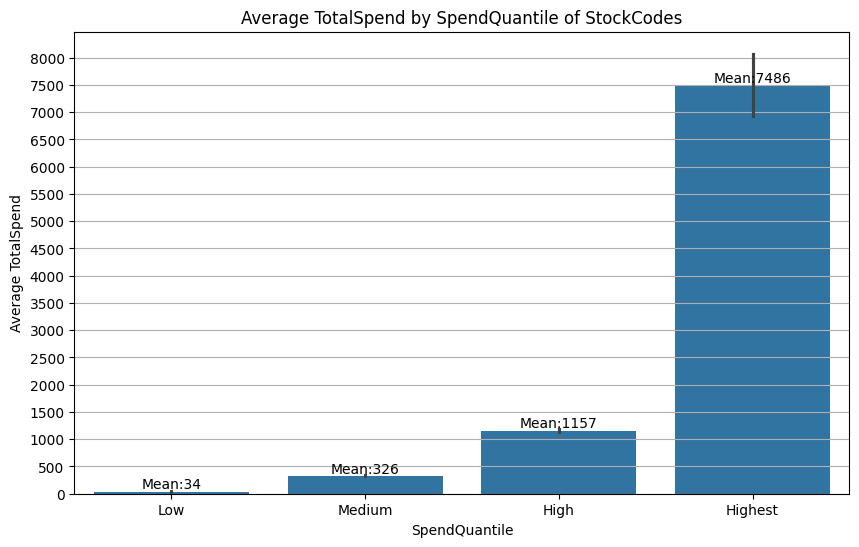

HighestSpend Stock 
 1290    22423
Name: StockCode, dtype: object 
 HighSpend Stock 
 12        15036
18      15056BL
19       15056N
20       15056P
29        16014
         ...   
3275      85150
3276      85152
3296      85175
3299      85178
3306     85184C
Name: StockCode, Length: 918, dtype: object 
 MediumSpend Stock 
 0        10002
6        10125
7        10133
8        10135
9        11001
         ...  
3331     85212
3338     85227
3344    85231B
3348    85232D
3433     90057
Name: StockCode, Length: 918, dtype: object 
 LowSpend Stock 
 1        10080
2        10120
3       10123C
4       10124A
5       10124G
         ...  
3668    90214V
3669    90214W
3670    90214Y
3671    90214Z
3672         D
Name: StockCode, Length: 1836, dtype: object


In [ ]:
def StocktSpendQuantile( df, StockCode, TotalSpend, quantiles = 4,interval = 500):
  df_CLV = df.groupby('StockCode')['TotalSpend'].sum().reset_index()
  df_CLV['TotalSpend'].fillna(0, inplace=True)

  qlabels = ['Low', 'Medium', 'High', 'Highest']
   # Calculate quantiles and handle cases with fewer than 'quantiles' unique quantiles
  qbins = pd.qcut(df_CLV['TotalSpend'], q = quantiles, labels = False, retbins = True, duplicates = 'drop')[1] #only edges [min_value, q1, q2, q3, max_value].
  num_bins = len(qbins) - 1 #coz bins have edges which has 1 values extra than quantiles

  if num_bins < quantiles: # if less than 4 quantiles as mentioned in method
    print(f"Warning: Not enough data to create {quantiles} quantiles. Reducing to {num_bins}.")
    quantiles = num_bins
    qlabels = qlabels[:num_bins] # Adjust labels to match reduced quantiles
    qbins = qbins[:num_bins + 1]  # Adjust bins to match reduced quantiles 1



  # Adjust bin access, SpendQuantile assignment, and labels based on the number of bins
  if num_bins > 0: # changed condition check based on the warning implementation
      # Use custom labels if available, otherwise use numerical labels
      df_CLV['SpendQuantile'] = pd.cut(df_CLV['TotalSpend'], bins=qbins,
                                      labels=qlabels if num_bins <= len(qlabels) else False,
                                      include_lowest=True, duplicates='drop')

       #Access segments based on quantiles, handling potential IndexError
      df_CLV_highest = df_CLV[df_CLV['TotalSpend'] >= qbins[-1]].get('StockCode') if num_bins > 0 else pd.Series([], dtype=object)
      df_CLV_high = df_CLV[(df_CLV['TotalSpend'] < qbins[-1]) & (df_CLV['TotalSpend'] >= qbins[-2])].get('StockCode') if num_bins > 1 else pd.Series([], dtype=object)
      df_CLV_medium = df_CLV[(df_CLV['TotalSpend'] < qbins[-2]) & (df_CLV['TotalSpend']>= qbins[-3])].get('StockCode') if num_bins > 2 else pd.Series([], dtype=object)
      df_CLV_low = df_CLV[(df_CLV['TotalSpend'] < qbins[-3])]['StockCode'] if num_bins > 2 else pd.Series([], dtype=object)


  else:
    df_CLV['SpendQuantile'] = qlabels[0] if qlabels else 'High'
    df_CLV_highest = df_CLV.get('StockCode')
    df_CLV_high = pd.Series([], dtype=object)
    df_CLV_medium = pd.Series([], dtype=object)
    df_CLV_low = pd.Series([], dtype=object)


  print(df_CLV.sort_values('TotalSpend'))
  #plot
  plt.figure(figsize=(10, 6))
  sns.barplot(data = df_CLV, x = 'SpendQuantile', y = 'TotalSpend')
  plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(interval))  # Adjust the quantiles to your preference
  plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.0f}'))

  try:
    plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))

  except ValueError:
    print("Warning: x-axis tick step could not be set to 1. Data might be too close together.")

  # Add mean value for each quantile box as text on top of the bars
  for quantile, group in df_CLV.groupby('SpendQuantile'):
      if len(group) == 1:
          mean_value = group['TotalSpend'].values[0]  # Access the single value directly
      else:
          mean_value = group['TotalSpend'].mean()
      plt.text(quantile, mean_value, f'Mean:{mean_value:.0f}', ha='center', va='bottom', color='black')



  plt.xlabel('SpendQuantile')
  plt.ylabel('Average TotalSpend')
  plt.title('Average TotalSpend by SpendQuantile of StockCodes')
  plt.grid( axis = 'y')
  plt.show()

  return print("HighestSpend Stock",'\n',df_CLV_highest, "\n HighSpend Stock",'\n',df_CLV_high,"\n MediumSpend Stock" ,'\n',df_CLV_medium,"\n LowSpend Stock" ,'\n',df_CLV_low)

StocktSpendQuantile(dfps, 'StockCode', 'TotalSpend')


#Quantile of Customer's frequency of orders

Each cluster shows customer's order frequency

to segregate loyal customers

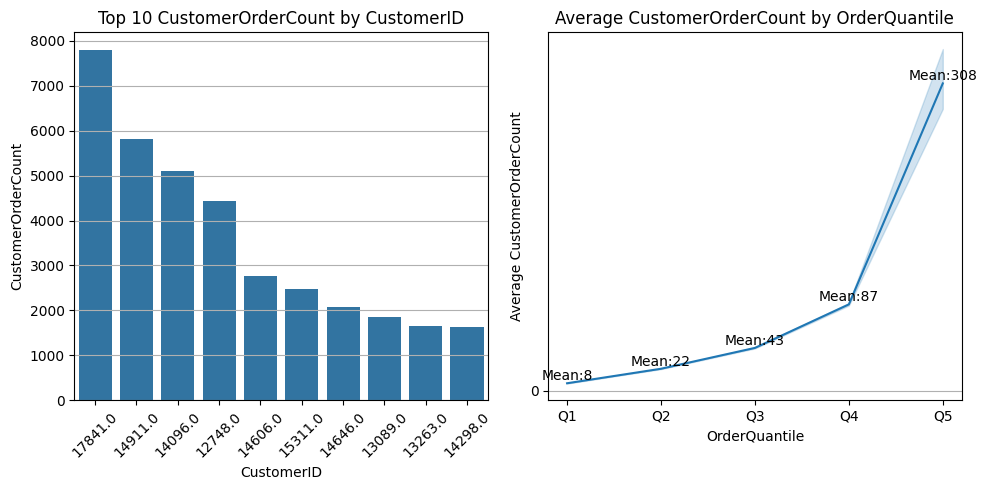

      CustomerID  CustomerOrderCount OrderQuantile
3623     17331.0                   1            Q1
4239     18174.0                   1            Q1
3946     17763.0                   1            Q1
2724     16078.0                   1            Q1
2325     15524.0                   1            Q1
...          ...                 ...           ...
1654     14606.0                2755            Q5
322      12748.0                4440            Q5
1283     14096.0                5095            Q5
1871     14911.0                5809            Q5
3996     17841.0                7800            Q5

[4321 rows x 3 columns]
Top 10 Customers by Order Count:
      CustomerID  CustomerOrderCount OrderQuantile
3996     17841.0                7800            Q5
1871     14911.0                5809            Q5
1283     14096.0                5095            Q5
322      12748.0                4440            Q5
1654     14606.0                2755            Q5
2168     15311.0        

In [ ]:


def CustOrders(df, cust_column, year_column, quantiles=5, interval = 500):

  """Calculates quantiles for stock order counts and adds them to the DataFrame."""
  # Adjust quantile labels based on num_quantiles if custom labels are not provided
  df_cust = df.groupby('CustomerID')['Year'].count().reset_index()
  df_cust.rename(columns = { year_column: 'CustomerOrderCount'}, inplace = True)
  df_cust['CustomerOrderCount'].fillna(0, inplace=True)
  df_cust.sort_values(by='CustomerOrderCount', ascending=False, inplace=True)



  qlabels = [f'Q{i+1}' for i in range(quantiles)]
  # Calculate quantiles and handle cases with fewer than 'quantiles' unique quantiles
  qbins = pd.qcut(df_cust['CustomerOrderCount'], q = quantiles, labels = False, retbins = True, duplicates = 'drop')[1]
  num_bins = len(qbins) - 1


  if num_bins < quantiles:
    print(f"Warning: Not enough data to create {quantiles} quantiles. Reducing to {num_bins}.")
    quantiles = num_bins
    qlabels = qlabels[:num_bins] # Adjust labels to match reduced quantiles
    qbins = qbins[:num_bins + 1]  # Adjust bins to match reduced quantiles


    # Adjust bin access, SpendQuantile assignment, and labels based on the number of bins
  if num_bins > 0: # changed condition check based on the warning implementation
      # Use custom labels if available, otherwise use numerical labels
      df_cust['OrderQuantile'] = pd.cut(df_cust['CustomerOrderCount'], bins=qbins,
                                      labels=qlabels if num_bins <= len(qlabels) else False,
                                      include_lowest=True, duplicates='drop')

  # Access segments based on quantiles, handling potential IndexError
      df_cust_highest = df_cust[df_cust['CustomerOrderCount']>= qbins[-1]]['CustomerID'] if num_bins > 0 else pd.Series([], dtype = object)
      df_cust_high = df_cust[(df_cust['CustomerOrderCount'] < qbins[-1]) & (df_cust['CustomerOrderCount'] >= qbins[-2])]['CustomerID'] if num_bins > 1 else pd.Series([], dtype=object)
      df_cust_medium = df_cust[(df_cust['CustomerOrderCount'] < qbins[-2]) & (df_cust['CustomerOrderCount'] >= qbins[-3])]['CustomerID'] if num_bins > 2 else pd.Series([], dtype=object)
      df_cust_low = df_cust[(df_cust['CustomerOrderCount'] < qbins[-3])]['CustomerID'] if num_bins > 2 else pd.Series([], dtype=object)


  else:
      df_cust['OrderQuantile'] = qlabels[0] if qlabels else 'High'
      df_cust_highest = df_cust.get('CustomerID')
      df_cust_high = pd.Series([], dtype=object)
      df_cust_medium = pd.Series([], dtype=object)
      df_cust_low = pd.Series([], dtype=object)




  if df_cust is None:
        print("Quantiles have not been calculated yet.")
        return

  fig, axes = plt.subplots(1, 2, figsize=(10, 5))
  # Barplot for Top 10 CustomerOrderCount
  sns.barplot(x="CustomerID", y="CustomerOrderCount",
              data=df_cust[:10],
              order=df_cust['CustomerID'][:10],
              ax = axes[0])


    # Add mean value for each quantile box as text on top of the bars
  # for i, bar in enumerate(axes[0].patches):
  #   value = df_cust[df_cust['CustomerID'] == bar.get_x()]['CustomerOrderCount'].values[0]
  #   axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{value:.0f}', ha='center', va='bottom', color='black')

  # Rotate x-ticks for the first plot
  axes[0].set_xlabel('CustomerID')
  axes[0].set_ylabel('CustomerOrderCount')
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)  # Rotate the x-ticks here
  axes[0].set_title('Top 10 CustomerOrderCount by CustomerID')
  axes[0].grid(axis='y')



  # Plot for quantiles
  sns.lineplot(data= df_cust, x='OrderQuantile', y='CustomerOrderCount', ax=axes[1])

  # Rotate x-ticks for the second plot
  axes[1].set_xlabel('OrderQuantile')
  axes[1].set_ylabel('Average CustomerOrderCount')
  axes[1].set_title('Average CustomerOrderCount by OrderQuantile')
  axes[1].grid(axis='y')

  # Custom y-axis tick formatting for the second plot
  axes[1].yaxis.set_major_locator(ticker.MultipleLocator(interval))  # Adjust the interval to your preference
  axes[1].yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.0f}'))

  # Add mean value for each quantile box as text on top of the bars
  for quantile, group in df_cust.groupby('OrderQuantile'):
      if len(group) == 1:
          mean_value = group['CustomerOrderCount'].values[0]  # Access the single value directly
      else:
          mean_value = group['CustomerOrderCount'].mean()
      axes[1].text(quantile, mean_value, f'Mean:{mean_value:.0f}', ha='center', va='bottom', color='black')

  plt.tight_layout()
  plt.show()

  # Print top 10 stocks
  print(df_cust.sort_values('CustomerOrderCount'))
  print("Top 10 Customers by Order Count:")
  print(df_cust[:10])


  return df_cust

df0 = CustOrders(dfps, 'CustomerID', 'Year')

#Quantile of StockCode Ordered frequently
Each quantile shows frequency of orders by StockCode- from highest to lowest

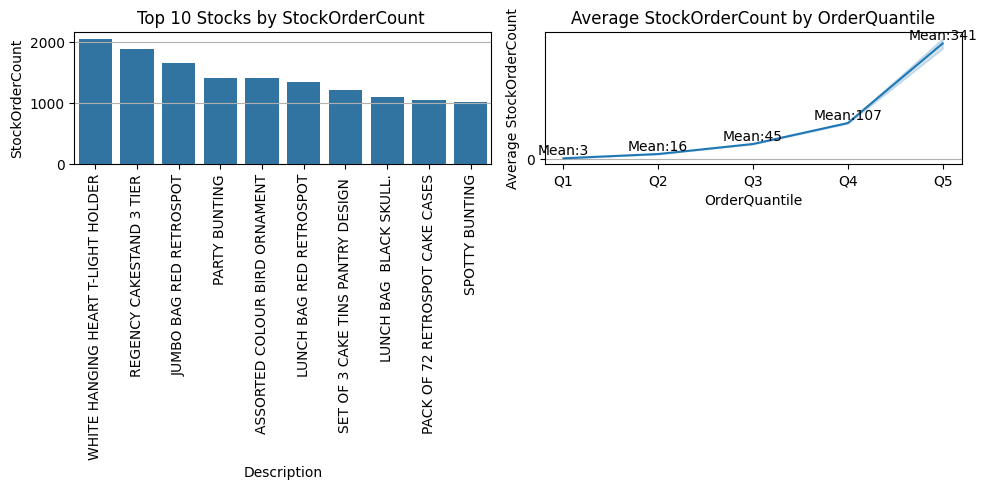

     StockCode                          Description  StockOrderCount  \
2610    35004P           SET OF 3 PINK FLYING DUCKS                1   
2029     23104           IVORY PANTRY HANGING LAMP                 1   
2031     23106                ZINC PLANT POT HOLDER                1   
1255     22351             DOTCOMGIFTSHOP TEA TOWEL                1   
2658     35832  WOOLLY HAT SOCK GLOVE ADVENT STRING                1   
...        ...                                  ...              ...   
3284     84879        ASSORTED COLOUR BIRD ORNAMENT             1405   
2803     47566                        PARTY BUNTING             1409   
3456    85099B              JUMBO BAG RED RETROSPOT             1657   
1320     22423             REGENCY CAKESTAND 3 TIER             1889   
3471    85123A   WHITE HANGING HEART T-LIGHT HOLDER             2057   

     OrderQuantile  
2610            Q1  
2029            Q1  
2031            Q1  
1255            Q1  
2658            Q1  
...      

In [ ]:
def StockOrders(df, stock_column, desc_column ,year_column, quantiles=5, interval = 500):
  """Calculates quantiles for stock order counts and adds them to the DataFrame."""
  df_stock = df.groupby(['StockCode', 'Description'])['Year'].count().reset_index()
  df_stock.rename(columns = { year_column: 'StockOrderCount'}, inplace = True)
  df_stock['StockOrderCount'].fillna(0, inplace=True)
  df_stock.sort_values(by='StockOrderCount', ascending=False, inplace=True)

  # Calculate quantiles
  qlabels = [f'Q{i+1}' for i in range(quantiles)]
  qbins = pd.qcut(df_stock['StockOrderCount'], q = quantiles, labels = False, retbins = True, duplicates = 'drop')[1]
  num_bins = len(qbins) - 1

  if num_bins < quantiles:
      print(f"Warning: Not enough data to create {quantiles} quantiles. Reducing to {num_bins}.")
      quantiles = num_bins
      qlabels = qlabels[:num_bins] # Adjust labels to match reduced quantiles
      qbins = qbins[:num_bins + 1]  # Adjust bins to match reduced quantiles


  if num_bins > 0:
      # Use custom labels if available, otherwise use numerical labels
      df_stock['OrderQuantile'] = pd.cut(df_stock['StockOrderCount'], bins = qbins,
                                      labels=qlabels if num_bins <= len(qlabels) else False,
                                      include_lowest=True, duplicates='drop')

      stock_highest = df_stock[df_stock['StockOrderCount']>= qbins[-1]]['StockCode'] if num_bins > 0 else pd.Series([], dtype = object)
      stock_high = df_stock[(df_stock['StockOrderCount'] < qbins[-1]) & (df_stock['StockOrderCount'] >= qbins[-2])]['StockCode'] if num_bins > 1 else pd.Series([], dtype=object)
      stock_medium = df_stock[(df_stock['StockOrderCount'] < qbins[-2]) & (df_stock['StockOrderCount'] >= qbins[-3])]['StockCode'] if num_bins > 2 else pd.Series([], dtype=object)
      stock_low = df_stock[(df_stock['StockOrderCount'] < qbins[-3])]['StockCode'] if num_bins > 2 else pd.Series([], dtype=object)


  else:
      df_stock['OrderQuantile'] = qlabels[0] if qlabels else 'High'
      stock_highest = df_stock.get('StockCode')
      stock_high = pd.Series([], dtype=object)
      stock_medium = pd.Series([], dtype=object)
      stock_low = pd.Series([], dtype=object)

  if df_stock is None:
      print("Quantiles have not been calculated yet.")
      return

  """Plots the top 10 stock items by Stock_OrderCount."""

  fig, axes = plt.subplots(1, 2, figsize=(10, 5))
  # Barplot for Top 10 CustomerOrderCount
  sns.barplot(x="Description", y="StockOrderCount",
              data=df_stock[:10],
              order=df_stock['Description'][:10],
              ax = axes[0])

  # Rotate x-ticks for the first plot
  axes[0].set_xlabel('Description')
  axes[0].set_ylabel('StockOrderCount')
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)  # Rotate the x-ticks here
  axes[0].set_title('Top 10 Stocks by StockOrderCount ')
  axes[0].grid(axis='y')

  # Plot for quantiles
  sns.lineplot(data=df_stock, x='OrderQuantile', y='StockOrderCount', ax=axes[1])

  # Rotate x-ticks for the second plot
  axes[1].set_xlabel('OrderQuantile')
  axes[1].set_ylabel('Average StockOrderCount')
  axes[1].set_title('Average StockOrderCount by OrderQuantile')
  axes[1].grid(axis='y')

  for quantile, group in df_stock.groupby('OrderQuantile'):
    if len(group) == 1:
        mean_value = group['StockOrderCount'].values[0]  # Access the single value directly
    else:
        mean_value = group['StockOrderCount'].mean()

    axes[1].text(quantile, mean_value, f'Mean:{mean_value:.0f}', ha='center', va='bottom', color='black')

  # Custom y-axis tick formatting for the second plot
  axes[1].yaxis.set_major_locator(ticker.MultipleLocator(interval))  # Adjust the interval to your preference
  axes[1].yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.0f}'))

  plt.tight_layout()
  plt.show()

  # Print top 10 stocks
  print(df_stock.sort_values('StockOrderCount'))
  print("Top 10 Stocks by Order Count:")
  print(df_stock[:10])

StockOrders(dfps, 'StockCode', 'Description' ,'Year')

#Recency according to CustomerID
High Recency per CustomerID -  shows recent Customer_engagement
lower the value, more latest it is (ref -  in Quantile column)



Df       CustomerID  Recency
0        12347.0        2
1        12348.0       75
2        12349.0       19
3        12350.0      310
4        12352.0       36
...          ...      ...
4316     18280.0      278
4317     18281.0      181
4318     18282.0        8
4319     18283.0        4
4320     18287.0       43

[4321 rows x 2 columns]
df_recent_quantile       CustomerID  Recency Recent_Engagement_quantile
0        12347.0        2                 Quantile_1
1        12348.0       75                 Quantile_3
2        12349.0       19                 Quantile_2
3        12350.0      310                 Quantile_4
4        12352.0       36                 Quantile_2
...          ...      ...                        ...
4316     18280.0      278                 Quantile_4
4317     18281.0      181                 Quantile_4
4318     18282.0        8                 Quantile_1
4319     18283.0        4                 Quantile_1
4320     18287.0       43                 Quantile_2

[432

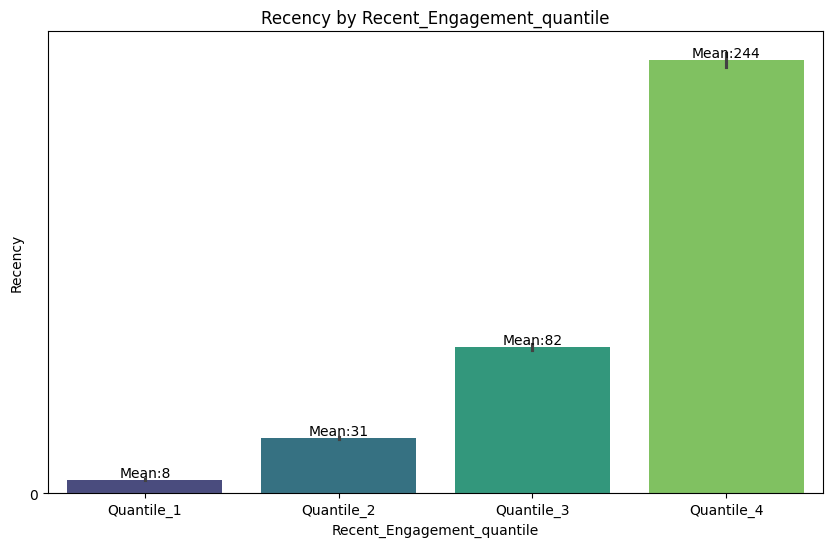

MostLatest Customers 
 (1126,) 
 Latest Customers 
 (1068,) 
 Older Customers 
 (1047,) 
 Oldest Customers 
 (1080,)


In [ ]:
def CustRecency(df, cust_col, recency_col , quantiles = 4, interval = 500):

  latest = df['InvoiceDate'].max() + timedelta(1)
  df['CustomerID'].astype(str)
  df = df.groupby('CustomerID').agg({ 'InvoiceDate' : lambda x : (latest - x.max()).days}).reset_index()
  df.rename(columns = {'InvoiceDate' : 'Recency'}, inplace = True)
  df['Recency'].fillna(0, inplace=True)
  df.sort_values(by='CustomerID', inplace=True)
  print("Df", df)

  # Check if there is only one row (one CustomerID)
  if len(df['CustomerID'].unique()) == 1:
      print("Only one customer found. Assigning to Quantile 1.")
      df['Recent_Engagement_quantile'] = 'Quantile_1'
      qlabels = ['Quantile_1']
      qbins = [df['Recency'].min(), df['Recency'].max()]  # Min and max will be the same in this case
      num_bins = 1
  else:
      qlabels = [f'Quantile_{i+1}' for i in range(quantiles)]
      qbins = pd.qcut(df['Recency'], q=quantiles, labels=False, retbins=True, duplicates='drop')[1]
      num_bins = len(qbins) - 1

  if num_bins < quantiles:
    print(f"Warning: Not enough data to create {quantiles} quantiles. Reducing to {num_bins}.")

    quantiles = num_bins
    qlabels = qlabels[:num_bins] # Adjust labels to match reduced quantiles
    qbins = qbins[:num_bins + 1]  # Adjust bins to match reduced quantiles


  if num_bins > 0:
    # Use custom labels if available, otherwise use numerical labels
    df['Recent_Engagement_quantile'] = pd.cut(df['Recency'], bins = qbins,
                                    labels=qlabels if num_bins <= len(qlabels) else False,
                                    include_lowest=True, duplicates='drop')

    print('df_recent_quantile', df)
    print('Qbins', qbins)
    print('qlabels', qlabels)
    cust_MostLatest = df[df['Recency'] <= qbins[1]] if num_bins > 0 else pd.Series([], dtype=object)
    cust_Latest = df[(df['Recency'] > qbins[1]) & (df['Recency'] <= qbins[2])]if num_bins > 1 else pd.Series([], dtype=object)
    cust_older = df[(df['Recency'] > qbins[2]) & (df['Recency'] <= qbins[3])] if num_bins > 2 else pd.Series([], dtype=object)
    cust_oldest = df[df['Recency'] > qbins[3]]if num_bins > 2 else pd.Series([], dtype=object)

    df_cust_ML = df[df['Recent_Engagement_quantile'] == 'Quantile_1'].sort_values(by = 'CustomerID').reset_index()
    df_cust_L = df[df['Recent_Engagement_quantile'] == 'Quantile_2'].sort_values(by = 'CustomerID').reset_index()
    df_cust_old = df[df['Recent_Engagement_quantile'] == 'Quantile_3'].sort_values(by = 'CustomerID').reset_index()
    df_cust_oldest = df[df['Recent_Engagement_quantile'] == 'Quantile_4'].sort_values(by = 'CustomerID').reset_index()
    #print('cust_ML', df_cust_ML)
    #print('cust_L', df_cust_L)
    #print('cust_old', df_cust_old)
    #print('cust_oldest', df_cust_oldest)

      # Get the CustomerID lists from the dataframes, with checks
    df_cust_ML_IDs = df_cust_ML.get('CustomerID', pd.Series([], dtype=object)) if not df_cust_ML.empty else pd.Series([], dtype=object)
    df_cust_L_IDs = df_cust_L.get('CustomerID', pd.Series([], dtype=object)) if not df_cust_L.empty else pd.Series([], dtype=object)
    df_cust_old_IDs = df_cust_old.get('CustomerID', pd.Series([], dtype=object)) if not df_cust_old.empty else pd.Series([], dtype=object)
    df_cust_oldest_IDs = df_cust_oldest.get('CustomerID', pd.Series([], dtype=object)) if not df_cust_oldest.empty else pd.Series([], dtype=object)

  else :
    df['Recent_Engagement_quantile'] = qlabels[0] if qlabels else 'High'
    cust_MostLatest = df.get('CustomerID')
    cust_Latest = pd.Series([], dtype = object)
    cust_older = pd.Series([], dtype = object)
    cust_oldest = pd.Series([], dtype = object)

    df_cust_ML = df_cust_L = df_cust_old = df_cust_oldest = pd.DataFrame()
    #print('cust_ML', df_cust_ML)
    #print('cust_L', df_cust_ML)
    #print('cust_old', df_cust_ML)
    #print('cust_oldest', df_cust_ML)
    df_cust_ML_IDs = df_cust_L_IDs = df_cust_old_IDs = df_cust_oldest_IDs = pd.Series([], dtype=object)

    # df_cust_ML_IDs = df_cust_ML.get('CustomerID', pd.Series([], dtype=object)) if not df_cust_ML.empty else pd.Series([], dtype=object)
    # df_cust_L_IDs = df_cust_L.get('CustomerID', pd.Series([], dtype=object)) if not df_cust_L.empty else pd.Series([], dtype=object)
    # df_cust_old_IDs = df_cust_old.get('CustomerID', pd.Series([], dtype=object)) if not df_cust_old.empty else pd.Series([], dtype=object)
    # df_cust_oldest_IDs = df_cust_oldest.get('CustomerID', pd.Series([], dtype=object)) if not df_cust_oldest.empty else pd.Series([], dtype=object)



  if df is None:
    print("Quantiles have not been calculated yet.")

  #print(df.sort_values('Recency'))
  # print("Top 10 Customers by Recency:")
  # print(df.iloc[:10])


  plt.figure(figsize=(10, 6))
  sns.barplot(data = df, x = 'Recent_Engagement_quantile', y = 'Recency', palette= 'viridis')

  plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(interval))  # Adjust the interval to your preference
  plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.0f}'))

  try:
    plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))

  except ValueError:
    print("Warning: x-axis tick step could not be set to 1. Data might be too close together.")

   # Add mean value for each quantile box as text on top of the bars
  for quantile, group in df.groupby('Recent_Engagement_quantile'):
      if len(group) == 1:
          mean_value = group['Recency'].values[0]  # Access the single value directly
      else:
          mean_value = group['Recency'].mean()
      plt.text(quantile, mean_value, f'Mean:{mean_value:.0f}', ha='center', va='bottom', color='black')

  plt.xlabel('Recent_Engagement_quantile')
  plt.ylabel('Recency')
  plt.title('Recency by Recent_Engagement_quantile')
  plt.grid(axis='y')
  plt.show()

  return print("MostLatest Customers",'\n',df_cust_ML_IDs.shape, "\n Latest Customers",'\n',df_cust_L_IDs.shape,"\n Older Customers" ,'\n',df_cust_old_IDs.shape,"\n Oldest Customers" ,'\n',df_cust_oldest_IDs.shape)
CustRecency(dfps, 'CustomerID', 'Recency')

#Recency according to StockCode

High Recency StockCode indicates  - recent StockCode bought

In [ ]:
a = 4

len(range(a))
c = [i for i in range(a)]
c

[0, 1, 2, 3]

Df      StockCode  Recency
1836     22993        1
1296     22429        1
2353     23545        1
1291     22424        1
1290     22423        1
...        ...      ...
271      20957      373
2792     82615      373
607      21488      373
860      21895      374
3044     84854      374

[3673 rows x 2 columns]
df_recent_quantile      StockCode  Recency Recent_Engagement_quantile
1836     22993        1                 Quantile_1
1296     22429        1                 Quantile_1
2353     23545        1                 Quantile_1
1291     22424        1                 Quantile_1
1290     22423        1                 Quantile_1
...        ...      ...                        ...
271      20957      373                 Quantile_3
2792     82615      373                 Quantile_3
607      21488      373                 Quantile_3
860      21895      374                 Quantile_3
3044     84854      374                 Quantile_3

[3673 rows x 3 columns]
Qbins [  1.   4.  37. 374.]


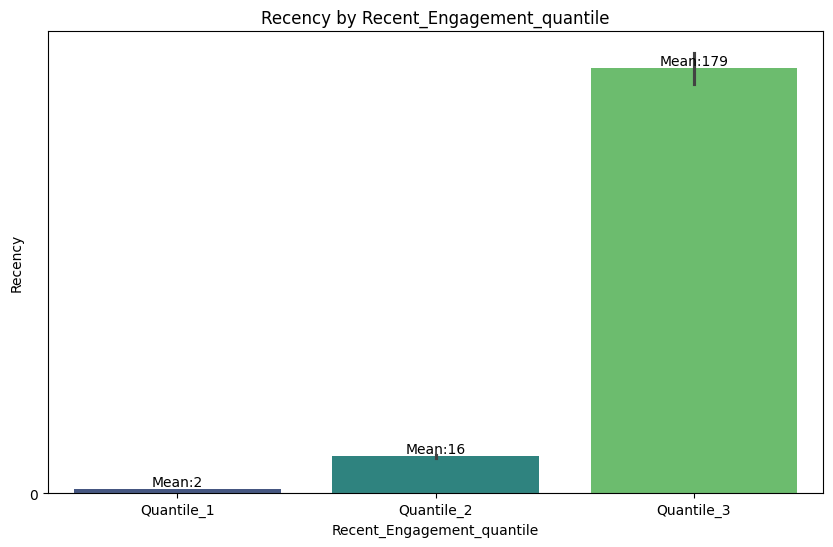

MostLatest StockCodes 
 0        10125
1        10135
2        11001
3        15030
4        15039
         ...  
1955    90214U
1956    90214V
1957    90214W
1958    90214Y
1959    90214Z
Name: StockCode, Length: 1960, dtype: object 
 Latest StockCodes 
 0       10080
1       10120
2      10124A
3      10124G
4       15034
        ...  
800    90209A
801    90210D
802    90211A
803    90211B
804         D
Name: StockCode, Length: 805, dtype: object 
 Older StockCodes 
 0       10002
1      10123C
2       10133
3      15044B
4      15058C
        ...  
903    90209B
904    90209C
905    90210A
906    90212B
907    90212C
Name: StockCode, Length: 908, dtype: object 
 Oldest StockCodes 
 Series([], dtype: object)


In [ ]:
def StockRecency(df, stock_col, recency_col , quantiles = 4, interval = 500):
  latest = df['InvoiceDate'].max() + timedelta(1)

  df = df.groupby('StockCode').agg({ 'InvoiceDate' : lambda x : (latest - x.max()).days}).reset_index()
  df.rename(columns = {'InvoiceDate' : 'Recency'}, inplace = True)
  df['Recency'].fillna(0, inplace=True)
  df.sort_values(by='Recency', inplace=True)
  print("Df", df)

  if df['StockCode'].nunique() == 1:
      print("Only one StockCode found. Assigning to Quantile 1.")
      df['Recent_Engagement_quantile'] = 'Quantile_1'
      qlabels = ['Quantile_1']
      qbins = [df['Recency'].min(), df['Recency'].max()]  # Min and max will be the same in this case
      num_bins = 1
      # Check if there is only one row (one CustomerID)

  else:
    qlabels = [f'Quantile_{i+1}' for i in range(quantiles)]
    qbins = pd.qcut(df['Recency'], q = quantiles, labels = False, retbins = True, duplicates = 'drop')[1]
    num_bins = len(qbins) - 1

  if num_bins < quantiles: #comparing with quantiles
    print(f"Warning: Not enough entries to create {quantiles} quantiles. Reducing to {num_bins}.")
    quantiles = num_bins
    qlabels = qlabels[:num_bins] # Adjust labels to match reduced quantiles
    qbins = qbins[:num_bins + 1]  # Adjust bins to match reduced quantiles


  if num_bins > 0: #changed condition check based on the warning implementation

    # Use custom labels if available, otherwise use numerical labels
    df['Recent_Engagement_quantile'] = pd.cut(df['Recency'], bins = qbins,
                                    labels=qlabels if num_bins <= len(qlabels) else False,
                                    include_lowest=True, duplicates='drop')

    print('df_recent_quantile', df)
    print('Qbins', qbins)
    print('qlabels', qlabels)
    # stock_Mlatest = df[df['Recency'] <= qbins[1]] if num_bins > 0 else pd.Series([], dtype=object)
    # stock_Latest = df[(df['Recency'] > qbins[1]) & (df['Recency'] <= qbins[2])]if num_bins > 1 else pd.Series([], dtype=object)
    # stock_older = df[(df['Recency'] > qbins[2]) & (df['Recency'] <= qbins[3])] if num_bins > 2 else pd.Series([], dtype=object)
    # stock_oldest = df[df['Recency'] > qbins[3]]if num_bins > 2 else pd.Series([], dtype=object)


    df_stock_ML= df[df['Recent_Engagement_quantile'] == 'Quantile_1'].sort_values(by = 'StockCode').reset_index()
    df_stock_L = df[df['Recent_Engagement_quantile'] == 'Quantile_2'].sort_values(by = 'StockCode').reset_index()
    df_stock_old = df[df['Recent_Engagement_quantile'] == 'Quantile_3'].sort_values(by = 'StockCode').reset_index()
    df_stock_oldest = df[df['Recent_Engagement_quantile'] == 'Quantile_4'].sort_values(by = 'StockCode').reset_index()
    # print('stock_ML', df_stock_ML)
    # print('stock_L', df_stock_L)
    # print('stock_old', df_stock_old)
    # print('stock_oldest', df_stock_oldest)

     # Get the CustomerID lists from the dataframes, with checks
    df_stock_ML_IDs = df_stock_ML.get('StockCode', pd.Series([], dtype=object)) if not df_stock_ML.empty else pd.Series([], dtype=object)
    df_stock_L_IDs = df_stock_L.get('StockCode', pd.Series([], dtype=object)) if not df_stock_L.empty else pd.Series([], dtype=object)
    df_stock_old_IDs = df_stock_old.get('StockCode', pd.Series([], dtype=object)) if not df_stock_old.empty else pd.Series([], dtype=object)
    df_stock_oldest_IDs = df_stock_oldest.get('StockCode', pd.Series([], dtype=object)) if not df_stock_oldest.empty else pd.Series([], dtype=object)



  else :
    df['Recent_Engagement_quantile'] = qlabels[0] if qlabels else 'Quantile_1'
    stock_MostLatest = df.get('StockCode')
    stock_Latest = pd.Series([], dtype = object)
    stock_older = pd.Series([], dtype = object)
    stock_oldest = pd.Series([], dtype = object)


    df_stock_ML = df_stock_L = df_stock_old = df_stock_oldest = pd.DataFrame()
    # print('stock_ML', df_stock_ML)
    # print('stock_L', df_stock_L)
    # print('stock_old', df_stock_old)
    # print('stock_oldest', df_stock_oldest)

    # Get the CustomerID lists from the dataframes, with checks
    df_stock_ML_IDs = df_stock_L_IDs = df_stock_old_IDs = df_stock_oldest_IDs = pd.Series([], dtype=object)

  if df is None:
    print("Quantiles have not been calculated yet.")

  #print(df.sort_values('Recency'))


  plt.figure(figsize=(10, 6))
  sns.barplot(data = df, x = 'Recent_Engagement_quantile', y = 'Recency', palette= 'viridis')

  plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(interval))  # Adjust the interval to your preference
  plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.0f}'))

  try:
    plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))

  except ValueError:
    print("Warning: x-axis tick step could not be set to 1. Data might be too close together.")

   # Add mean value for each quantile box as text on top of the bars
  for quantile, group in df.groupby('Recent_Engagement_quantile'):
      if len(group) == 1:
          mean_value = group['Recency'].values[0]  # Access the single value directly
      else:
          mean_value = group['Recency'].mean()
      plt.text(quantile, mean_value, f'Mean:{mean_value:.0f}', ha='center', va='bottom', color='black')

  plt.xlabel('Recent_Engagement_quantile')
  plt.ylabel('Recency')
  plt.title('Recency by Recent_Engagement_quantile')
  plt.grid(axis='y')
  plt.show()

  return print("MostLatest StockCodes",'\n',df_stock_ML_IDs, "\n Latest StockCodes",'\n',df_stock_L_IDs,"\n Older StockCodes" ,'\n',df_stock_old_IDs,"\n Oldest StockCodes" ,'\n',df_stock_oldest_IDs)
  #return print("MostLatest StockCodes",'\n',df_stock_ML, "\n Latest StockCodes",'\n',df_stock_L,"\n Older StockCodes" ,'\n',df_stock_old,"\n Oldest StockCodes" ,'\n',df_stock_oldest)

StockRecency(dfps, 'StockCode', 'Recency')

#Customers who have not purchased since a long time

In [ ]:
def Cust_old(df, cust_col, recency_col):
  latest = df['InvoiceDate'].max() + timedelta(1)
  df['CustomerID'].astype(str)

  df = df.groupby('CustomerID').agg({ 'InvoiceDate' : lambda x : (latest - x.max()).days}).reset_index()
  df.rename(columns = {'InvoiceDate' : 'Last_purchased'}, inplace = True)
  df['Last_purchased'].fillna(0, inplace=True)

  df.sort_values(by='CustomerID', inplace=True)
  print("DF \n", df)

  mean = df['Last_purchased'].mean()
  print("Mean of latest purchased :", mean)

  old_cust = df[df['Last_purchased'] > mean]#.reset_index()
  old_cust_IDs = old_cust.get('CustomerID').to_list()
  print("Old_custs \n ", old_cust)
  print("Old_cust_IDs \n ", old_cust_IDs)

  percentage = len(old_cust_IDs) / df['CustomerID'].count() * 100
  print(f'old_cust.count() : {len(old_cust_IDs)}')
  print(f'Percentage {type(percentage)}')
  print(f"Percentage of old customers: {percentage:.2f}% out of total {len(df['CustomerID'])}")
  return

Cust_old(dfps, 'CustomerID', 'Recency')

DF 
       CustomerID  Last_purchased
0        12347.0               2
1        12348.0              75
2        12349.0              19
3        12350.0             310
4        12352.0              36
...          ...             ...
4316     18280.0             278
4317     18281.0             181
4318     18282.0               8
4319     18283.0               4
4320     18287.0              43

[4321 rows x 2 columns]
Mean of latest purchased : 90.67924091645452
Old_custs 
        CustomerID  Last_purchased
3        12350.0             310
5        12353.0             204
6        12354.0             232
7        12355.0             214
13       12361.0             287
...          ...             ...
4304     18260.0             173
4306     18262.0             140
4309     18269.0             358
4316     18280.0             278
4317     18281.0             181

[1419 rows x 2 columns]
Old_cust_IDs 
  [12350.0, 12353.0, 12354.0, 12355.0, 12361.0, 12363.0, 12365.0, 12373.0, 12377.

#Average time between each Customer's purchase

df_recent_quantile       CustomerID  Order_Count                 min                 max  \
0        12347.0          182 2010-12-07 14:57:00 2011-12-07 15:52:00   
1        12348.0           27 2010-12-16 19:09:00 2011-09-25 13:13:00   
2        12349.0           72 2011-11-21 09:51:00 2011-11-21 09:51:00   
3        12350.0           16 2011-02-02 16:01:00 2011-02-02 16:01:00   
4        12352.0           84 2011-02-16 12:33:00 2011-11-03 14:37:00   
...          ...          ...                 ...                 ...   
4316     18280.0           10 2011-03-07 09:52:00 2011-03-07 09:52:00   
4317     18281.0            7 2011-06-12 10:53:00 2011-06-12 10:53:00   
4318     18282.0           13 2011-08-05 13:35:00 2011-12-02 11:43:00   
4319     18283.0          719 2011-01-06 14:14:00 2011-12-06 12:02:00   
4320     18287.0           70 2011-05-22 10:39:00 2011-10-28 09:29:00   

      Purchase_Time_Diff  Avg_Order_Freq Avg_Order_Freq_Quantile  
0                    365        2.016

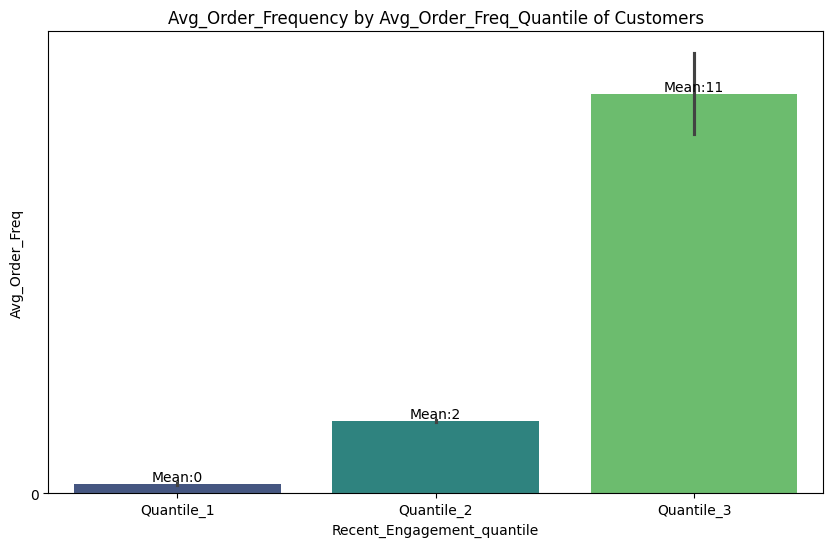

Most Frequent Buyers 
 0       12349.0
1       12350.0
2       12353.0
3       12354.0
4       12355.0
         ...   
2156    18269.0
2157    18278.0
2158    18280.0
2159    18281.0
2160    18283.0
Name: CustomerID, Length: 2161, dtype: float64 Frequent Buyers 
 
 0       12347.0
1       12359.0
2       12360.0
3       12364.0
4       12370.0
         ...   
1075    18261.0
1076    18265.0
1077    18272.0
1078    18276.0
1079    18287.0
Name: CustomerID, Length: 1080, dtype: float64 Less frequent buyers
 
 0       12348.0
1       12352.0
2       12356.0
3       12358.0
4       12363.0
         ...   
1075    18263.0
1076    18270.0
1077    18273.0
1078    18277.0
1079    18282.0
Name: CustomerID, Length: 1080, dtype: float64 lowest frequency buyers 
 
 Series([], dtype: object)


In [ ]:
def Avg_time_between_purchases(df, cust_col, date_col, quantiles = 4, interval = 500):
  df['CustomerID'].astype(str)
  df = df[['CustomerID', 'InvoiceDate']].sort_values('CustomerID')

  df['Order_Count'] = df.groupby('CustomerID')['InvoiceDate'].transform('count')
  df['Order_Count'].fillna(1, inplace=True)
  df.sort_values(by='CustomerID', inplace=True)
  df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

  df = df.groupby(['CustomerID', 'Order_Count'])['InvoiceDate'].agg(['min', 'max']).reset_index()
  df.sort_values(by='CustomerID', inplace=True)
  df['Purchase_Time_Diff'] = (df['max'] - df['min']).dt.days
  df['Avg_Order_Freq'] = df['Purchase_Time_Diff'] / (df['Order_Count']-1)
  df['Avg_Order_Freq'].fillna(1, inplace=True)

  if df['CustomerID'].nunique() == 1:
    print("Only one CustomerID found. Assigning to Quantile 1.")
    df['Order_Freq_Quantile'] = 'Quantile_1'
    qlabels = ['Quantile_1']
    qbins = [df['Avg_Order_Freq'].min(), df['Avg_Order_Freq'].max()]  # Min and max will be the same in this case
    num_bins = 1
    # Check if there is only one row (one CustomerID)

  else:
    qlabels = [f'Quantile_{i+1}' for i in range(quantiles)]
    qbins = pd.qcut(df['Avg_Order_Freq'], q = quantiles, labels = False, retbins = True, duplicates = 'drop')[1]
    num_bins = len(qbins) - 1

  if num_bins < quantiles:
    print(f"Warning: Not enough data to create {quantiles} quantiles. Reducing to {num_bins}.")
    quantiles = num_bins
    qlabels = qlabels[:num_bins] # Adjust labels to match reduced quantiles
    qbins = qbins[:num_bins + 1]  # Adjust bins to match reduced quantiles


  if num_bins > 0:

    df['Avg_Order_Freq_Quantile'] = pd.cut(df['Avg_Order_Freq'], bins = qbins,
                                    labels=qlabels if num_bins <= len(qlabels) else False,
                                    include_lowest=True, duplicates='drop')

    print('df_recent_quantile', df)
    print('Qbins', qbins)
    print('qlabels', qlabels)

    M_freq = df[df['Avg_Order_Freq'] <= qbins[1]] if num_bins > 0 else pd.Series([], dtype=object)
    Freq = df[(df['Avg_Order_Freq'] > qbins[1]) & (df['Avg_Order_Freq'] <= qbins[2])]if num_bins > 1 else pd.Series([], dtype=object)
    L_Frew = df[(df['Avg_Order_Freq'] > qbins[2]) & (df['Avg_Order_Freq'] <= qbins[3])] if num_bins > 2 else pd.Series([], dtype=object)
    VL_Freq = df[df['Avg_Order_Freq'] > qbins[3]]if num_bins > 2 else pd.Series([], dtype=object)


    df_M_freq= df[df['Avg_Order_Freq_Quantile'] == 'Quantile_1'].sort_values(by = 'CustomerID').reset_index()
    df_Freq = df[df['Avg_Order_Freq_Quantile'] == 'Quantile_2'].sort_values(by = 'CustomerID').reset_index()
    df_L_Freq = df[df['Avg_Order_Freq_Quantile'] == 'Quantile_3'].sort_values(by = 'CustomerID').reset_index()
    df_VL_Freq = df[df['Avg_Order_Freq_Quantile'] == 'Quantile_4'].sort_values(by = 'CustomerID').reset_index()
    # print('stock_ML', df_stock_ML)
    # print('stock_L', df_stock_L)
    # print('stock_old', df_stock_old)
    # print('stock_oldest', df_stock_oldest)

     # Get the CustomerID lists from the dataframes, with checks
    df_M_freq_IDs = df_M_freq.get('CustomerID', pd.Series([], dtype=object)) if not df_M_freq.empty else pd.Series([], dtype=object)
    df_Freq_IDs = df_Freq.get('CustomerID', pd.Series([], dtype=object)) if not df_Freq.empty else pd.Series([], dtype=object)
    df_L_Freq_IDs = df_L_Freq.get('CustomerID', pd.Series([], dtype=object)) if not df_L_Freq.empty else pd.Series([], dtype=object)
    df_VL_Freq_IDs = df_VL_Freq.get('CustomerID', pd.Series([], dtype=object)) if not df_VL_Freq.empty else pd.Series([], dtype=object)

  else:
    df['Avg_Order_Freq_Quantile'] = qlabels[0] if qlabels else 'Quantile_1'
    M_freq = df.get('CustomerID')
    Freq = pd.Series([], dtype = object)
    L_Frew = pd.Series([], dtype = object)
    VL_Freq = pd.Series([], dtype = object)

    df_M_freq = df_Freq = df_L_Freq = df_VL_Freq = pd.DataFrame()

    df_M_freq_IDs = df_Freq_IDs = df_L_Freq_IDs = df_VL_Freq_IDs = pd.Series([], dtype=object)
    # print('stock_L', df_stock_L)
    # print('stock_old', df_stock_old)
    # print('stock_oldest', df_stock_oldest



  if df is None:
    print("Quantiles have not been calculated yet.")


  plt.figure(figsize=(10, 6))
  sns.barplot(data = df, x = 'Avg_Order_Freq_Quantile', y = 'Avg_Order_Freq', palette= 'viridis')

  plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(interval))  # Adjust the interval to your preference
  plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.0f}'))

  try:
    plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))

  except ValueError:
    print("Warning: x-axis tick step could not be set to 1. Data might be too close together.")

   # Add mean value for each quantile box as text on top of the bars
  for quantile, group in df.groupby('Avg_Order_Freq_Quantile'):
      if len(group) == 1:
          mean_value = group['Avg_Order_Freq'].values[0]  # Access the single value directly
      else:
          mean_value = group['Avg_Order_Freq'].mean()
      plt.text(quantile, mean_value, f'Mean:{mean_value:.0f}', ha='center', va='bottom', color='black')

  plt.xlabel('Recent_Engagement_quantile')
  plt.ylabel('Avg_Order_Freq')
  plt.title('Avg_Order_Frequency by Avg_Order_Freq_Quantile of Customers')
  plt.grid(axis='y')
  plt.show()

  return print('Most Frequent Buyers', '\n', df_M_freq_IDs, 'Frequent Buyers \n', '\n', df_Freq_IDs, 'Less frequent buyers\n', '\n', df_L_Freq_IDs, 'lowest frequency buyers \n', '\n', df_VL_Freq_IDs)

Avg_time_between_purchases(dfps, 'CustomerID', 'InvoiceDate')

#Find decling frequency of orders by month
Comparing each CustomerIDs Average Monthly orders to their Latest 3 Month's TotalQty's Average


In [ ]:
def declining_freq_by3Months (df, cust_col, month_col, stock_col, qty_col, date_col):
  df['CustomerID'].astype(str)
  df_custMonthlyTotal = df.groupby([cust_col, month_col])[qty_col].sum().reset_index()
  df_custMonthlyTotal.rename(columns = {qty_col : 'TotalMonthlyQty'}, inplace = True)
  df_custMonthlyTotal = df_custMonthlyTotal.sort_values(by = [cust_col, month_col], ascending = [True, False])
  # print(df_custMonthlyTotal)

  df_custMonthlyTotal['Avg_monthly_qty'] = df_custMonthlyTotal.groupby(cust_col)['TotalMonthlyQty'].transform('mean')
  df_custMonthlyTotal['Avg_monthly_qty'].fillna(1, inplace =True)
  df_custMonthlyTotal.sort_values(by = [cust_col])
  # print(df_custMonthlyTotal)

  df_custMonthlyTotal = df_custMonthlyTotal.groupby(cust_col).head(3)
  df_custMonthlyTotal['3MonthTotalQty'] = df_custMonthlyTotal.groupby(cust_col)['TotalMonthlyQty'].transform('sum')
  df_custMonthlyTotal['3MonthAvgQty'] = df_custMonthlyTotal['3MonthTotalQty']/3

  df_custMonthlyTotal['Trend'] = np.where(df_custMonthlyTotal['3MonthAvgQty'] < df_custMonthlyTotal['Avg_monthly_qty'], 'Decline', 'Normal')
  df_custMonthlyTotal = df_custMonthlyTotal.drop_duplicates(subset=[cust_col], keep = 'first')
  print(df_custMonthlyTotal)

  print(df_custMonthlyTotal['Trend'].value_counts())

  cust_decline = df_custMonthlyTotal[df_custMonthlyTotal['Trend'] == 'Decline'].get(cust_col).unique()
  print('Declining Order Frequency Customers',pd.Series(cust_decline).sort_values())

  cust_normal = df_custMonthlyTotal[df_custMonthlyTotal['Trend'] == 'Normal'].get(cust_col).unique()
  print('Normal or Increasing Order Frequwncy Customers',pd.Series(cust_normal).sort_values())

  return

declining_freq_by3Months(dfps, 'CustomerID', 'Month', 'StockCode', 'Quantity', 'InvoiceDate')

# Clusters of CustomerID's "frequency" of buying particular StockCodes

Each cluster shows CustomerID's frequency of each stockcode


In [ ]:
dfps4 = dfps[['CustomerID', 'StockCode', 'Quantity', 'TotalSpend']]
dfps4.sort_values(by='CustomerID')

,CustomerID,StockCode,Quantity,TotalSpend
428961,12347.0,22375,8,34.00
428962,12347.0,22371,12,47.40
428963,12347.0,22374,8,34.00
428964,12347.0,22252,12,15.00
428965,12347.0,22945,12,10.20
...,...,...,...,...
198726,18287.0,84507C,6,15.30
198727,18287.0,84920,4,15.00
198728,18287.0,22807,6,17.70
198730,18287.0,20963,30,37.50


In [ ]:
df_custstock = dfps4.groupby(['CustomerID', 'StockCode'])['Quantity'].sum().reset_index()
df_custstock.rename(columns = {'Quantity' : 'TotalQty'}, inplace = True)
df_custstock.sort_values(by = 'TotalQty')

,CustomerID,StockCode,TotalQty
159992,15838.0,84347,-9360
155774,15749.0,47566B,-1300
184593,16422.0,D,-723
27313,12901.0,D,-240
227581,17389.0,85071A,-150
...,...,...,...
180590,16333.0,21915,8120
184523,16422.0,17003,10077
180595,16333.0,84077,10080
254154,17949.0,22197,11692


In [ ]:
df_custstock_NotZero = df_custstock[df_custstock['TotalQty'] > 0]
df_custstock_NotZero['CustomerID'].nunique()

4321

In [ ]:
df_custstock_NotZero['StockCode'].nunique()

3642

In [ ]:
# Filter out Customers with less than a certain threshold of total purchases
customer_purchase_threshold = 5
customer_activity = df_custstock_NotZero.groupby('CustomerID')['TotalQty'].sum()
active_customers = customer_activity[customer_activity >= customer_purchase_threshold].index
df_custstock_NotZero_filtered = df_custstock_NotZero[df_custstock_NotZero['CustomerID'].isin(active_customers)]

# Filter out StockCodes with less than a certain number of customers buying them
stockcode_purchase_threshold = 10
stockcode_activity = df_custstock_NotZero_filtered.groupby('StockCode')['CustomerID'].nunique()
popular_stockcodes = stockcode_activity[stockcode_activity >= stockcode_purchase_threshold].index
df_custstock_NotZero_filtered1 = df_custstock_NotZero_filtered[df_custstock_NotZero_filtered['StockCode'].isin(popular_stockcodes)]

# Create a pivot table again after filtering
df_custstock_NotZero_matrix_filtered = pd.pivot(df_custstock_NotZero_filtered, columns='StockCode', index='CustomerID', values='TotalQty').fillna(0)
df_custstock_NotZero_matrix_filtered

StockCode,10002,10080,10120,10123C,10124A,10124G,10125,10133,10135,11001,...,90214O,90214P,90214R,90214S,90214T,90214U,90214V,90214W,90214Y,90214Z
CustomerID,,,,,,,,,,,,,,,,,,,,,
12347.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12348.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12349.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12350.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12352.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18280.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18281.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18282.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df_custstock_NotZero.sort_values(by = 'TotalQty')
df_custstock_NotZero[df_custstock_NotZero['TotalQty'] ==2]

,CustomerID,StockCode,TotalQty
160,12349.0,22832,2
163,12349.0,23108,2
164,12349.0,23112,2
172,12349.0,23283,2
178,12349.0,23460,2
...,...,...,...
266502,18283.0,23509,2
266503,18283.0,23510,2
266504,18283.0,23551,2
266518,18283.0,84380,2


In [ ]:
df_custstock_NotZero_matrix = pd.pivot(df_custstock_NotZero, columns = 'StockCode', index = 'CustomerID', values = 'TotalQty').fillna(0)
df_custstock_NotZero_matrix

StockCode,10002,10080,10120,10123C,10124A,10124G,10125,10133,10135,11001,...,90214O,90214P,90214R,90214S,90214T,90214U,90214V,90214W,90214Y,90214Z
CustomerID,,,,,,,,,,,,,,,,,,,,,
12347.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12348.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12349.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12350.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12352.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18280.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18281.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18282.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
dfps4_scaled = scaler.fit_transform(df_custstock_NotZero_matrix)

In [ ]:
pca = PCA(n_components=95)
df_custstock_NotZero_matrix_pca = pca.fit_transform(df_custstock_NotZero_matrix)
print('\n ', pca.explained_variance_ratio_)

cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
print("cumulative_variance \n",cumulative_variance)
n_components_95 = np.argmax(cumulative_variance > 0.95) + 1

print(f'Number of components to retain 95% variance: {n_components_95}')


  [0.10882612 0.09748186 0.08451656 0.06294979 0.05760258 0.05112464
 0.04442831 0.04045166 0.03876655 0.03100346 0.02836267 0.01957358
 0.01734164 0.01662242 0.01494244 0.01362013 0.01238475 0.01195535
 0.01030476 0.01002873 0.00935686 0.0088701  0.00835426 0.00819474
 0.00741919 0.00667318 0.00648654 0.00612136 0.0059808  0.00526247
 0.0051419  0.00484558 0.0046474  0.00454033 0.00428924 0.00407698
 0.00395844 0.00366378 0.00338683 0.00315783 0.0030669  0.00274255
 0.0026037  0.00245174 0.00226295 0.00221013 0.00215299 0.002093
 0.00194952 0.00191029 0.00171443 0.00165771 0.00163776 0.00161222
 0.00152598 0.00146862 0.00141358 0.00138118 0.00134676 0.00129301
 0.00127193 0.00123389 0.00120233 0.00119249 0.00116245 0.00113595
 0.00109902 0.00104711 0.00102148 0.00098753 0.00098071 0.00092652
 0.00091662 0.00089148 0.0008554  0.00084841 0.00081667 0.00080871
 0.00079569 0.0007677  0.00074581 0.00072739 0.00070835 0.00068707
 0.00066292 0.00063983 0.00063071 0.00062409 0.00061211 0.000

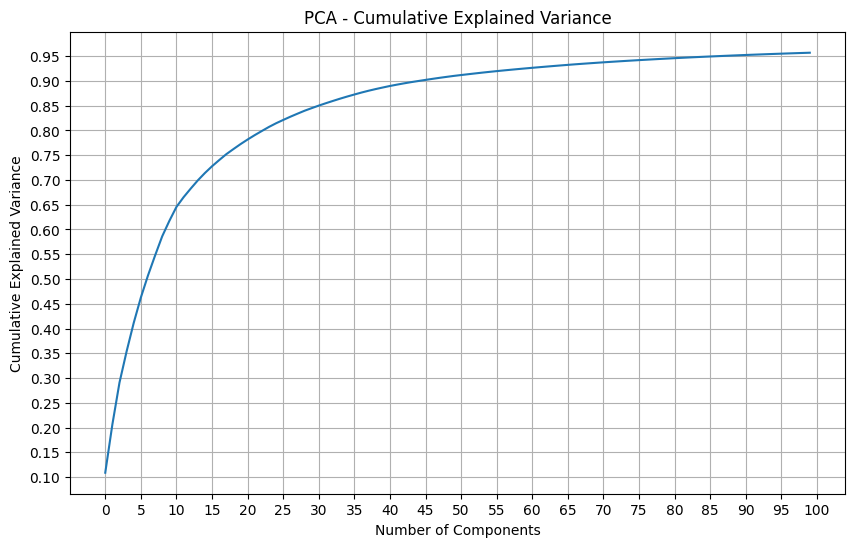

In [ ]:
pca = PCA(n_components = 100).fit(df_custstock_NotZero_matrix)
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(5))
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(0.05))
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA - Cumulative Explained Variance')
plt.grid()
plt.show()

In [ ]:
inertia = []

for num_clusters in np.arange(1, 20):
  kmeans = KMeans(n_clusters=num_clusters)
  kmeans.fit(df_custstock_NotZero_matrix_pca)
  inertia.append(kmeans.inertia_)
  print(f"Number of clusters: {num_clusters}, Inertia: {kmeans.inertia_}")

Number of clusters: 1, Inertia: 2385077597.624008
Number of clusters: 2, Inertia: 2174066164.5140805
Number of clusters: 3, Inertia: 1968397104.8225315
Number of clusters: 4, Inertia: 1865720929.902429
Number of clusters: 5, Inertia: 1644155407.1435018
Number of clusters: 6, Inertia: 1508489629.1396978
Number of clusters: 7, Inertia: 1400366619.9086692
Number of clusters: 8, Inertia: 1295028936.0041401
Number of clusters: 9, Inertia: 1198151054.6187894
Number of clusters: 10, Inertia: 1132998396.988525
Number of clusters: 11, Inertia: 1057543083.415883
Number of clusters: 12, Inertia: 1020238771.4251391
Number of clusters: 13, Inertia: 934809504.2499456
Number of clusters: 14, Inertia: 883920721.1530002
Number of clusters: 15, Inertia: 850711362.9700036
Number of clusters: 16, Inertia: 783146737.1410025
Number of clusters: 17, Inertia: 756063260.7061107
Number of clusters: 18, Inertia: 704082278.4779855
Number of clusters: 19, Inertia: 700010510.7944323


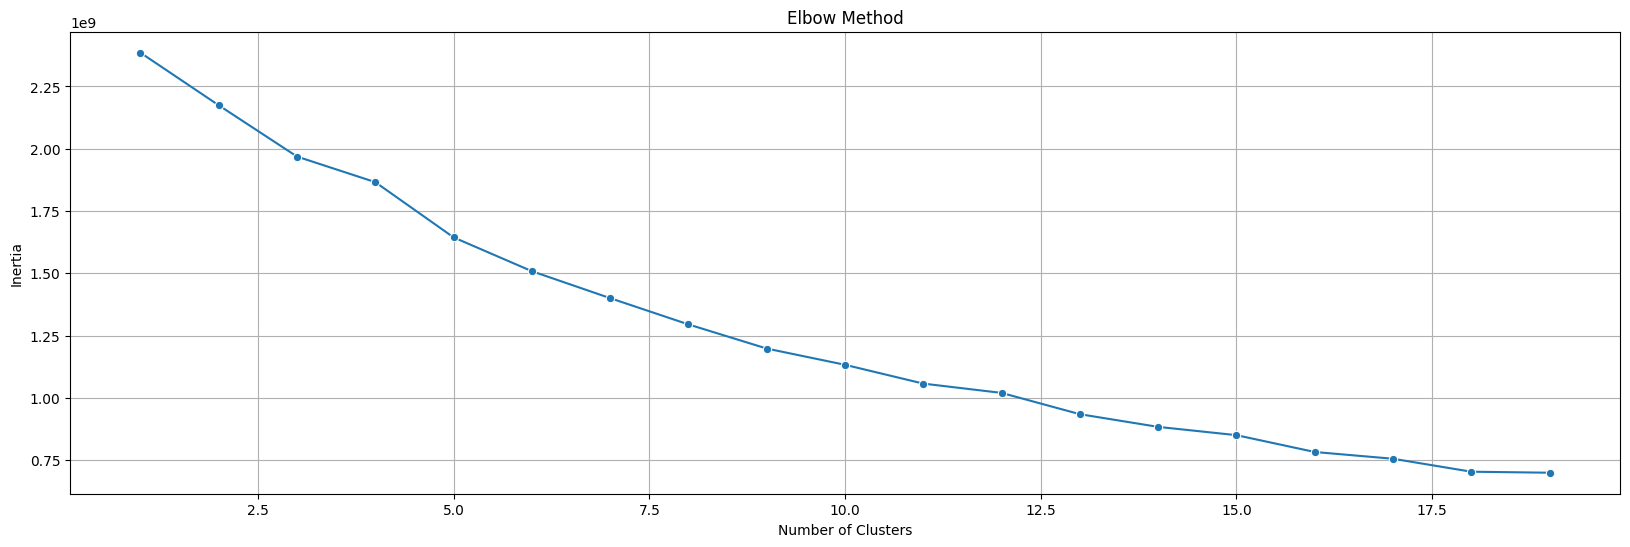

In [ ]:
plt.figure(figsize=(20, 6))
sns.lineplot(x = np.arange(1, 20), y = inertia, marker='o', linestyle='-')
plt.xlabel('Number of Clusters')
#plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(500))
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.grid()
plt.show()

In [ ]:
kmeans = KMeans(n_clusters = 5)
clusters = kmeans.fit_predict(df_custstock_NotZero_matrix_pca)
pd.DataFrame(clusters).value_counts()

,count
0,
0,4317
1,1
2,1
3,1
4,1


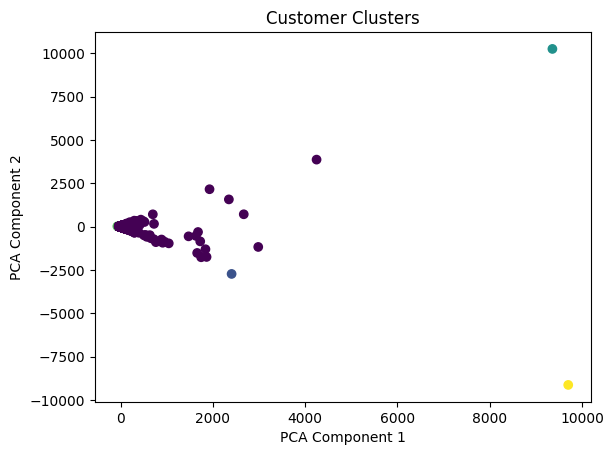

In [ ]:
plt.scatter(df_custstock_NotZero_matrix_pca[:, 0], df_custstock_NotZero_matrix_pca[:, 1], c=clusters)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Customer Clusters')
plt.show()

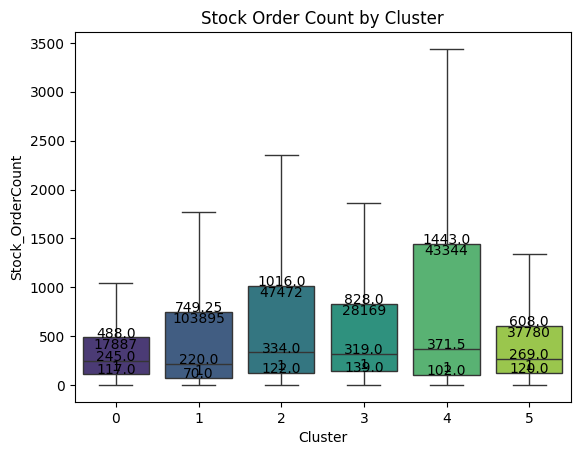

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# ... your code for data preparation (converting Cluster to string and grouping by Cluster)

# Create the boxplot
ax = sns.boxplot(x='Cluster', y='Stock_OrderCount', data=df_stock_cust_freq, showfliers=False, color='white', palette='viridis')

# Get the boxplot elements (containers instead of artists)
boxes = ax.containers

medians = df_stock_cust_freq.groupby('Cluster')['Stock_OrderCount'].median()
q1s = df_stock_cust_freq.groupby('Cluster')['Stock_OrderCount'].quantile(0.25)
q3s = df_stock_cust_freq.groupby('Cluster')['Stock_OrderCount'].quantile(0.75)
mins = df_stock_cust_freq.groupby('Cluster')['Stock_OrderCount'].min()
maxs = df_stock_cust_freq.groupby('Cluster')['Stock_OrderCount'].max()

# Calculate the y-axis range for better annotation placement
y_min, y_max = ax.get_ylim()
y_range = y_max - y_min

for i in range(len(boxes)):
    # Check if there are whiskers (may be empty for outliers)
    if len(boxes[i].whiskers) > 0:
        whisker_bottom = boxes[i].whiskers[0].get_ydata()[0]
        whisker_top = boxes[i].whiskers[-1].get_ydata()[0]  # Access last element
        # Annotate the minimum and maximum on the whiskers
        ax.annotate(str(mins[i]), xy=(i, whisker_bottom), horizontalalignment='center', va='bottom')
        ax.annotate(str(maxs[i]), xy=(i, whisker_top), horizontalalignment='center', va='top')
    else:
        # Handle cases without whiskers (optional: print a message)
        print(f"Cluster {i} has no whiskers")

    # Annotate the median, Q1, and Q3
    ax.annotate(str(medians[i]), xy=(i, medians[i]), horizontalalignment='center')
    ax.annotate(str(q1s[i]), xy=(i, q1s[i]), horizontalalignment='center')
    ax.annotate(str(q3s[i]), xy=(i, q3s[i]), horizontalalignment='center')


# Set labels and title
plt.xlabel('Cluster')
plt.ylabel('Stock_OrderCount')
plt.title('Stock Order Count by Cluster')


# Display the plot
plt.show()

In [ ]:
#example
"""data = {'theta': [1 for i in range(0,10)],
       'error': [10,20,21,22,23,24,25,26,27,28]}
df = pd.DataFrame(data=data)
gig,ax1 = plt.subplots(figsize=(8,5))
box_plot = sns.boxplot(x="theta", y='error', data=df, ax = ax1, showfliers = False)
min_value = df.groupby(['theta'])['error'].min().values

# get the lower whisker
#you can retreive other boxplot values as well
low_whisker = boxplot_stats(df.error)[0]['whislo']

for xtick in box_plot.get_xticks():
    ## idx = df[df['error']==min_value[xtick]].index.values
    text = 'The minimum value before outliers is here'
    box_plot.text(xtick,low_whisker-2, text,
            horizontalalignment='center',size='x-small',weight='semibold')
    box_plot.plot(xtick,low_whisker, marker='*', markersize=20)

## set the range to include the entire range of the data
ax1.set_yticks(np.arange(df.error.min(),df.error.max()+5,5))

plt.show()"""

'data = {\'theta\': [1 for i in range(0,10)],\n       \'error\': [10,20,21,22,23,24,25,26,27,28]}\ndf = pd.DataFrame(data=data)\ngig,ax1 = plt.subplots(figsize=(8,5))\nbox_plot = sns.boxplot(x="theta", y=\'error\', data=df, ax = ax1, showfliers = False)\nmin_value = df.groupby([\'theta\'])[\'error\'].min().values\n\n# get the lower whisker\n#you can retreive other boxplot values as well\nlow_whisker = boxplot_stats(df.error)[0][\'whislo\']\n\nfor xtick in box_plot.get_xticks():\n    ## idx = df[df[\'error\']==min_value[xtick]].index.values\n    text = \'The minimum value before outliers is here\'\n    box_plot.text(xtick,low_whisker-2, text,\n            horizontalalignment=\'center\',size=\'x-small\',weight=\'semibold\')\n    box_plot.plot(xtick,low_whisker, marker=\'*\', markersize=20)\n\n## set the range to include the entire range of the data\nax1.set_yticks(np.arange(df.error.min(),df.error.max()+5,5))\n\nplt.show()'

#Average Frequency, Spend and  Orders as per CustomerID with Loyalty scores
suggests CustomerID's spending per transaction - Highest to Lowest

In [ ]:
def AverageSpendCust(df, cust_col, date_col, qty_col, spend_col):
  df['CustomerID'].astype(str)
  df = df.groupby(cust_col).agg({date_col : 'count', spend_col : 'sum', qty_col : 'sum', }).reset_index()
  df.rename(columns = {date_col : 'Frequency',
                       spend_col : 'TotalSpend',
                       qty_col : 'TotalQty',
                       }, inplace = True)
  df['AverageSpend'] = df['TotalSpend'] / df['Frequency']
  df['AverageQty'] = df['TotalQty'] / df['Frequency']
  df = df[df['AverageSpend']>0]

  df.sort_values(by='AverageSpend', ascending=False, inplace=True)

  df['AverageSpend'].fillna(0, inplace=True)

  print('Average Spend _ Mean of all Customers', df['AverageSpend'].mean())
  print('Average of Qty of all customers', df['TotalQty'].mean())


  df['Frequency_Score'], binsF = pd.qcut(df['Frequency'], q=5, labels=False, retbins=True, duplicates='drop')
  labelsF = [f'{i+1}' for i in range(len(df['Frequency_Score'].unique()))] #returns string outputs
  label_to_int_F = {i: j+1 for j, i in enumerate(range(len(labelsF)))}
  df['Frequency_Score'] = df['Frequency_Score'].map(label_to_int_F)
  df['Frequency_Score'] = df['Frequency_Score'] * 0.5 #making the frequency weights half

  #Spend
  df['Spend_Score'], binsF = pd.qcut(df['TotalSpend'], q=5, labels=False, retbins=True, duplicates='drop')
  labelsS = [f'{i+1}' for i in range(len(df['Spend_Score'].unique()))] #returns string outputs
  label_to_int_S = {i: j+1 for j, i in enumerate(range(len(labelsS)))}
  df['Spend_Score'] = df['Spend_Score'].map(label_to_int_S)


  #Qty
  df['Qty_Score'], binsM = pd.qcut(df['TotalQty'], q=5, labels=False, retbins=True, duplicates='drop')
  labelsQ = [f'{i+1}' for i in range(len(df['Qty_Score'].unique()))]
  label_to_int_Q = {i: j+1 for j, i in enumerate(range(len(labelsQ)))}
  df['Qty_Score'] = df['Qty_Score'].map(label_to_int_Q)


  df['Spend_Score'].fillna(0, inplace=True)
  df['Qty_Score'].fillna(0, inplace=True)
  df['Frequency_Score'].fillna(0, inplace = True)

  # Check for NaN values in the mapped columns
  print("NaN values in 'Spend_Score':", df['Spend_Score'].isna().sum())
  print("NaN values in 'Qty_Score':", df['Qty_Score'].isna().sum())

  df['FSQ'] = df['Spend_Score'].astype(str) + df['Qty_Score'].astype(str) + df['Frequency_Score'].astype(str)

  df['Spend_Score'] = pd.to_numeric(df['Spend_Score'], errors='coerce')
  df['Qty_Score'] = pd.to_numeric(df['Qty_Score'], errors='coerce')
  df['Frequency_Score'] = pd.to_numeric(df['Frequency_Score'], errors='coerce')

  df['Spend_Score'].fillna(0, inplace=True)
  df['Qty_Score'].fillna(0, inplace=True)
  df['Frequency_Score'].fillna(0, inplace = True)

  df['Score'] = df['Spend_Score'].astype(int) + df['Qty_Score'].astype(int) + df['Frequency_Score'].astype(int)

  #loyaltycheck
  num_bins = 4
  # Check if there is only one customer
  if df['CustomerID'].nunique() == 1:
      # If only one customer, assign the entire group to a single loyalty label
      df['Loyalty'] = 'Loyal1'
  else:
      # Quantile distribution, duplicates dropped, retbins to get bins
      df['Loyalty'], bins = pd.qcut(df['Score'], q=num_bins, labels=False, duplicates='drop', retbins=True)

      unique_labels = [f'Loyal{i+1}' for i in range(len(df['Loyalty'].unique()))]

      df['Loyalty'] = df['Loyalty'].map(dict(enumerate(unique_labels)))

  df_loyalscorecard = df.groupby('Loyalty').agg({'Frequency' : 'mean','TotalSpend': 'mean','TotalQty': 'mean'})

  # Return the mean values grouped by Loyalty
  print('Loyalty Score Spend, Qty, Frequency \n ', df_loyalscorecard)

  #plot
  import plotly.express as px

  fig = px.bar(df_loyalscorecard, x=df_loyalscorecard.index, y=['Frequency', 'TotalSpend', 'TotalQty'],
              title='Loyalty Scorecard')
  fig.show()

  # #Plot
  # plt.figure(figsize=(20, 6))
  # sns.scatterplot(data = df.sort_values(by= 'AverageSpend', ascending = True)[:500], x = 'AverageQty', y = 'AverageSpend', palette= 'viridis')
  # #sns.violinplot(data = df, x = 'AverageSpend', y = 'AvgQty', palette= 'viridis')
  # # plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(1000))  # Adjust the interval to your preference
  # # plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.0f}'))
  # # plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(5))  # Adjust the interval to your preference
  # # plt.gca().xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.0f}'))
  # plt.xlabel('AverageQty')
  # plt.ylabel('AverageSpend')


  # #plt.xlabel('AverageSpend')
  # plt.xticks(rotation=45)
  # #plt.ylabel('AvgQty')
  # plt.title('AverageSpend vs AvgQty')
  # plt.grid(axis='y')
  # #plt.show()
  return df.sort_values(by = 'CustomerID')

AverageSpendCust(dfps, 'CustomerID', 'InvoiceDate','Quantity', 'TotalSpend' )

AverageSpend _ Mean of all Customers 33.391949037056975
Average number of Qty of all customers 1128.700925925926
NaN values in 'Spend_Score': 0
NaN values in 'Qty_Score': 0
Loyalty Score Spend, Qty, Frequency 
            Frequency   TotalSpend     TotalQty
Loyalty                                      
Loyal1    14.560144   194.071858    98.224417
Loyal2    35.341973   532.922023   298.710702
Loyal3    88.167126  1214.621331   737.182736
Loyal4   265.737242  6609.823757  3915.869707


,CustomerID,Frequency,TotalSpend,TotalQty,AverageSpend,AverageQty,Frequency_Score,Spend_Score,Qty_Score,FSQ,Score,Loyalty
0,12347.0,182,4310.00,2458,23.681319,13.505495,2.5,5,5,552.5,12,Loyal4
1,12348.0,27,1437.24,2332,53.231111,86.370370,1.0,4,5,451.0,10,Loyal3
2,12349.0,72,1457.55,630,20.243750,8.750000,2.0,4,4,442.0,10,Loyal3
3,12350.0,16,294.40,196,18.400000,12.250000,1.0,2,2,221.0,5,Loyal2
4,12352.0,84,1265.41,463,15.064405,5.511905,2.0,4,3,432.0,9,Loyal3
...,...,...,...,...,...,...,...,...,...,...,...,...
4316,18280.0,10,180.60,45,18.060000,4.500000,0.5,1,1,110.5,2,Loyal1
4317,18281.0,7,80.82,54,11.545714,7.714286,0.5,1,1,110.5,2,Loyal1
4318,18282.0,13,176.60,98,13.584615,7.538462,0.5,1,1,110.5,2,Loyal1
4319,18283.0,719,2039.58,1355,2.836690,1.884562,2.5,5,5,552.5,12,Loyal4


#Average Frequency, Spend and  Orders as per StockCodes with Loyalty scores

In [ ]:
def AverageSpendStock(df, stock_col, date_col, qty_col, spend_col, quantiles = 4):
  df = df.groupby('StockCode').agg({spend_col : 'sum', date_col : 'count', qty_col : 'sum'}).reset_index()
  df.rename(columns = {date_col : 'Frequency',
                      spend_col : 'TotalSpend',
                      qty_col : 'TotalQty'}, inplace = True)

  df['AverageSpend'] = df['TotalSpend'] / df['Frequency']
  df['AverageQty'] = df['TotalQty'] / df['Frequency']

  df = df[df['AverageSpend']>0]
  df.sort_values(by='AverageSpend', ascending=False, inplace=True)

  df['AverageSpend'].fillna(0, inplace=True)

  print('AverageSpend _ Mean of all Stocks', df['AverageSpend'].mean())
  print('Average number of orders of all stocks', df['Frequency'].mean())
  print('Average number of Qty of all stocks', df['TotalQty'].mean())

  df['Frequency_Score'], binsF = pd.qcut(df['Frequency'], q=5, labels=False, retbins=True, duplicates='drop')
  labelsF = [f'{i+1}' for i in range(len(df['Frequency_Score'].unique()))] #returns string outputs
  label_to_int_F = {i: j+1 for j, i in enumerate(range(len(labelsF)))}
  df['Frequency_Score'] = df['Frequency_Score'].map(label_to_int_F)
  df['Frequency_Score'] = df['Frequency_Score'] * 0.5 #making the frequency weights half

  #Spend
  df['Spend_Score'], binsF = pd.qcut(df['TotalSpend'], q=5, labels=False, retbins=True, duplicates='drop')
  labelsS = [f'{i+1}' for i in range(len(df['Spend_Score'].unique()))] #returns string outputs
  label_to_int_S = {i: j+1 for j, i in enumerate(range(len(labelsS)))}
  df['Spend_Score'] = df['Spend_Score'].map(label_to_int_S)


  #Qty
  df['Qty_Score'], binsM = pd.qcut(df['TotalQty'], q=5, labels=False, retbins=True, duplicates='drop')
  labelsQ = [f'{i+1}' for i in range(len(df['Qty_Score'].unique()))]
  label_to_int_Q = {i: j+1 for j, i in enumerate(range(len(labelsQ)))}
  df['Qty_Score'] = df['Qty_Score'].map(label_to_int_Q)


  df['Spend_Score'].fillna(0, inplace=True)
  df['Qty_Score'].fillna(0, inplace=True)

  # Check for NaN values in the mapped columns
  print("NaN values in 'Spend_Score':", df['Spend_Score'].isna().sum())
  print("NaN values in 'Qty_Score':", df['Qty_Score'].isna().sum())

  df['FSQ'] = df['Spend_Score'].astype(str) + df['Qty_Score'].astype(str) + df['Frequency_Score'].astype(str)
  df['Score'] = df['Spend_Score'].astype(int) + df['Qty_Score'].astype(int) + df['Frequency_Score'].astype(int)

  #loyaltycheck
  num_bins = 4
  # Check if there is only one customer
  if df[stock_col].nunique() == 1:
      # If only one customer, assign the entire group to a single loyalty label
      df['Loyalty'] = 'Loyal1'
  else:
      # Quantile distribution, duplicates dropped, retbins to get bins
      df['Loyalty'], bins = pd.qcut(df['Score'], q=num_bins, labels=False, duplicates='drop', retbins=True)

      unique_labels = [f'Loyal{i+1}' for i in range(len(df['Loyalty'].unique()))]

      df['Loyalty'] = df['Loyalty'].map(dict(enumerate(unique_labels)))

      df_loyalscorecard = df.groupby('Loyalty').agg({'Frequency' : 'mean','TotalSpend': 'mean','TotalQty': 'mean'})

  # Return the mean values grouped by Loyalty
  print('Loyalty Score Spend, Qty, Frequency \n ', df_loyalscorecard)

  #plot
  import plotly.express as px

  fig = px.bar(df_loyalscorecard, x=df_loyalscorecard.index, y=['Frequency', 'TotalSpend', 'TotalQty'],
              title='Loyalty Scorecard')
  fig.show()





#Plot
  # plt.figure(figsize=(20, 6))
  # sns.scatterplot(data = df.sort_values(by= 'AverageSpend', ascending = True)[:300], x = 'AverageQty', y = 'AverageSpend', palette= 'viridis')
  # plt.xlabel('AverageQty')
  # plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(5))  # Adjust the interval to your preference
  # plt.gca().xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.0f}'))
  # plt.xticks(rotation=45)
  # plt.grid()
  # plt.ylabel('AverageSpend')
  # plt.title('AverageSpend vs AverageQty')
  return df.sort_values(by = "AverageSpend")

AverageSpendStock(dfps, 'StockCode', 'InvoiceDate','Quantity', 'TotalSpend')

AverageSpend _ Mean of all Stocks 17.443497111914578
Average number of orders of all stocks 109.70313358988456
Average number of Qty of all stocks 1344.088785046729
NaN values in 'Spend_Score': 0
NaN values in 'Qty_Score': 0
Loyalty Score Spend, Qty, Frequency 
            Frequency   TotalSpend     TotalQty
Loyalty                                      
Loyal1    10.146752    96.078059    52.302326
Loyal2    40.009009   548.198739   358.259760
Loyal3   101.017877  1566.012480  1002.709497
Loyal4   324.566265  7690.974181  4444.033735


,StockCode,TotalSpend,Frequency,TotalQty,AverageSpend,AverageQty,Frequency_Score,Spend_Score,Qty_Score,FSQ,Score,Loyalty
3193,85047,0.80,4,0,0.200000,0.000000,0.5,1,1,110.5,2,Loyal1
2765,81953B,2.09,5,11,0.418000,2.200000,0.5,1,1,110.5,2,Loyal1
2822,84227,0.42,1,1,0.420000,1.000000,0.5,1,1,110.5,2,Loyal1
58,16202E,1.95,4,14,0.487500,3.500000,0.5,1,1,110.5,2,Loyal1
2568,47013C,4.06,8,31,0.507500,3.875000,0.5,1,1,110.5,2,Loyal1
...,...,...,...,...,...,...,...,...,...,...,...,...
1678,22830,2610.29,6,131,435.048333,21.833333,0.5,4,2,420.5,6,Loyal2
1156,22275,527.85,1,69,527.850000,69.000000,0.5,3,2,320.5,5,Loyal1
862,21897,1250.82,2,402,625.410000,201.000000,0.5,4,3,430.5,7,Loyal2
1681,22833,2503.53,4,75,625.882500,18.750000,0.5,4,2,420.5,6,Loyal2


#Frequency Per month: Number of purchases a customer has made over a specific period. Clusters

Number of clusters: 1, Inertia: 42323666.04443425
Number of clusters: 2, Inertia: 24375750.843757294
Number of clusters: 3, Inertia: 22360669.677090578
Number of clusters: 4, Inertia: 18087877.446934354
Number of clusters: 5, Inertia: 17120728.498015247
Number of clusters: 6, Inertia: 15033183.03651744
Number of clusters: 7, Inertia: 15202689.487005763
Number of clusters: 8, Inertia: 13465218.656176362
Number of clusters: 9, Inertia: 13032026.212180104
Enter the number of clusters: 5
Number of Customers in Clusters of 
  Month_Freq_Clusters
2    8113
0    4007
4    1042
3     113
1      41
Name: count, dtype: int64
                     Month    Frequency
Month_Freq_Clusters                    
0                        1    31.958678
0                        2    29.115207
0                        3    32.790780
0                        4    31.517647
0                        5    29.581081
0                        6    32.814371
0                        7    30.542955
0                

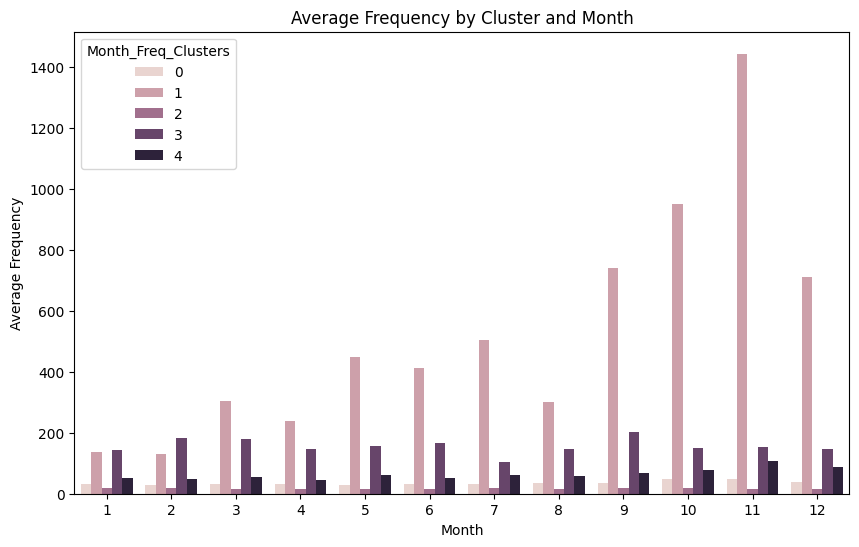

In [53]:
def freq_month(df, cust_col, month_col):
  df= df.groupby(cust_col)[month_col].value_counts().reset_index(name='Frequency')
  df.sort_values(by=cust_col)

  df_matrix = df.pivot(index=cust_col, columns=month_col, values='Frequency').fillna(0)
  df.fillna(0, inplace=True)
  #print(df_matrix)


  if df_matrix.shape[0] <= 1:
    df['Month_Freq_Clusters'] = 0
    print('Number of Customers in Clusters of \n ',df['Month_Freq_Clusters'].value_counts())

  else:

    inertia = []

    for clusters in np.arange(1,10):
      kmeans = KMeans(n_clusters=clusters)
      kmeans.fit(df_matrix)
      inertia.append(kmeans.inertia_)
      print(f'Number of clusters: {clusters}, Inertia: {kmeans.inertia_}')

    # results = pd.DataFrame({'clusters': np.arange(1,10), 'inertia' : inertia})
    # results.plot(x='clusters', y='inertia')
    # plt.title('Elbow Method')
    # plt.xlabel('Number of Clusters')
    # plt.ylabel('Inertia')
    # #plt.show()


    best_cluster = int(input('Enter the number of clusters: '))
    kmeans = KMeans(n_clusters=best_cluster)
    clusters = kmeans.fit_predict(df_matrix)

    mapping_dict = dict(zip(df_matrix.index , clusters))
    df['Month_Freq_Clusters'] = df[cust_col].map(mapping_dict)
    print('Number of Customers in Clusters of \n ',df['Month_Freq_Clusters'].value_counts())

    df_cluster_month = df.groupby(['Month_Freq_Clusters', 'Month']).agg({'Frequency': 'mean'}).reset_index()
    df_cluster_month.set_index('Month_Freq_Clusters', inplace=True)
    df_cluster_month.sort_index(inplace=True)
    print(df_cluster_month)

    plt.figure(figsize=(10, 6))


    #sns.lineplot(data=df_cluster_month, x='Month', y='Frequency', hue='Month_Freq_Clusters')

    # Create a bar plot using Seaborn for better color management
    sns.barplot(x='Month', y='Frequency', hue='Month_Freq_Clusters', data=df_cluster_month.reset_index())

    # Set the title and labels
    plt.title('Average Frequency by Cluster and Month')
    plt.xlabel('Month')
    plt.ylabel('Average Frequency')

    # Show the plot
    plt.show()

  return #df.sort_values(by='Frequency')

freq_month(dfps, 'CustomerID', 'Month')

# Peak sales Month, Day, DayOfmonth, DayofWeek

In [ ]:
def peak_sales_month(df, month_col, spend_col, qty_col, date_col):
  df = df.groupby(month_col).agg({ spend_col : 'sum',
                                  qty_col : 'sum',
                                   date_col : 'count'})#.reset_index()
  df.rename(columns={spend_col : 'Total_Spend',
                     qty_col : 'Total_Qty',
                     date_col : 'Frequency'}, inplace=True)
  df.sort_values(by='Total_Spend')

  #plot
  import plotly.express as px
  import plotly.graph_objects as go


    # Create the bar and line charts
  fig = px.bar(df, x=df.index, y=['Total_Spend', 'Total_Qty', 'Frequency'], title='Loyalty Scorecard')
  line_chart = px.line(df, x=df.index, y='Total_Spend', title='Total Spend by Month')
  # Add annotations to the line chart
  annotations = []
  for x, y in zip(df.index, df['Total_Spend']):
      annotations.append(dict(
          x=x,
          y=y,
          text=str(y),
          showarrow=True,
          arrowhead=2,
          textangle=45
      ))



  # Merge the data from fig and line_chart
  combined_fig = go.Figure(data=fig.data + line_chart.data)

  # Add the annotations to the combined figure
  combined_fig.update_layout(annotations=annotations)
   # Update the layout for the x-axis
  combined_fig.update_layout(xaxis_title='Month')
  combined_fig.update_xaxes(title_text=month_col)

  # Display the final merged figure with annotations
  combined_fig.show()

  return df.sort_values(by='Total_Spend')
peak_sales_month(dfps, 'Month', 'TotalSpend', 'Quantity', 'InvoiceNo')

,Total_Spend,Total_Qty,Frequency
Month,,,
4,419024.85,277460,22874
2,433365.03,261891,20009
1,472251.23,268799,21539
3,572943.79,343069,27364
7,580050.70,361123,27116
8,611592.09,386244,27315
6,640323.83,355977,27453
5,650323.12,368369,28502
12,888368.26,498646,43455


In [ ]:
def peak_day(df, day_col, spend_col, qty_col, date_col):
  df = df.groupby(day_col).agg({ spend_col : 'sum',
                                  qty_col : 'sum',
                                   date_col : 'count'}).sort_values(by = spend_col, ascending = False)
  df.rename(columns={spend_col : 'Total_Spend',
                     qty_col : 'Total_Qty',
                     date_col : 'Frequency'}, inplace=True)

  #plot
  import plotly.express as px
  import plotly.graph_objects as go


    # Create the bar and line charts
  fig = px.bar(df, x=df.index, y=['Total_Spend', 'Total_Qty', 'Frequency'], title='Loyalty Scorecard')
  line_chart = px.line(df, x=df.index, y='Total_Spend', title='Total Spend by Day')
  # Add annotations to the line chart
  annotations = []
  for x, y in zip(df.index, df['Total_Spend']):
      annotations.append(dict(
          x=x,
          y=y,
          text=str(y),
          showarrow=True,
          arrowhead=2,
          textangle=45
      ))



  # Merge the data from fig and line_chart
  combined_fig = go.Figure(data=fig.data + line_chart.data)

  # Add the annotations to the combined figure
  combined_fig.update_layout(annotations=annotations)
   # Update the layout for the x-axis
  combined_fig.update_layout(xaxis_title='Day')
  combined_fig.update_xaxes(title_text= day_col)

  # Display the final merged figure with annotations
  combined_fig.show()

  return df.sort_values(by='Total_Spend')
peak_day(dfps, 'Day', 'TotalSpend', 'Quantity', 'InvoiceNo')

,Total_Spend,Total_Qty,Frequency
Day,,,
31,131890.96,77823,6944
29,162015.19,97741,8123
26,177855.65,108908,8777
30,197096.96,112804,10056
27,209628.48,135542,12429
12,214445.43,133065,10629
25,217889.38,146463,11966
19,237143.04,149953,10909
23,237432.46,142940,14279


In [ ]:
def peak_sales_daymonth(df, day_col, month_col, spend_col, qty_col, date_col):
  df['Day_of_Month'] = df[day_col].astype(str) +"_" + df[month_col].astype(str)

  df = df.groupby('Day_of_Month').agg({ spend_col : 'sum',
                                  qty_col : 'sum',
                                   date_col : 'count'}).sort_values(by = spend_col, ascending = False)[:20]
  df.rename(columns={spend_col : 'Total_Spend',
                     qty_col : 'Total_Qty',
                     date_col : 'Frequency'}, inplace=True)
  df= df[['Total_Spend', 'Total_Qty', 'Frequency']].astype(int)

  #plot
  import plotly.express as px
  import plotly.graph_objects as go


    # Create the bar and line charts
  fig = px.bar(df, x=df.index, y=['Total_Spend', 'Total_Qty', 'Frequency'], title='Loyalty Scorecard')
  line_chart = px.line(df, x=df.index, y='Total_Spend', title='Total Spend by Day_of_Month')
  # Add annotations to the line chart
  annotations = []
  for x, y in zip(df.index, df['Total_Spend']):
      annotations.append(dict(
          x=x,
          y=y,
          text=str(y),
          showarrow=True,
          arrowhead=2,
          textangle=45
      ))



  # Merge the data from fig and line_chart
  combined_fig = go.Figure(data=fig.data + line_chart.data)

  # Add the annotations to the combined figure
  combined_fig.update_layout(annotations=annotations)
   # Update the layout for the x-axis
  combined_fig.update_layout(xaxis_title= 'Day_Month')
  combined_fig.update_xaxes(title_text='Day_of_Month')

  # Display the final merged figure with annotations
  combined_fig.show()

  return df.sort_values(by='Total_Spend')
peak_sales_daymonth(dfps, 'Day','Month', 'TotalSpend', 'Quantity', 'InvoiceNo')

,Total_Spend,Total_Qty,Frequency
Day_of_Month,,,
3_10,56638,24316,1734
9_11,57100,33617,2142
4_8,57126,37753,1494
10_6,57382,9493,708
12_5,58118,36948,1764
11_1,58980,25722,871
3_11,59328,32659,1945
21_10,60069,24170,1323
20_10,60296,40702,2285


In [ ]:
def peak_sales_hourday(df, day_col, hour_col, spend_col, qty_col, date_col):
  df['Hour_day'] = "H"+df[hour_col].astype(str) +"_" + "D"+df[day_col].astype(str)

  df = df.groupby('Hour_day').agg({ spend_col : 'sum',
                                  qty_col : 'sum',
                                   date_col : 'count'}).sort_values(by = spend_col, ascending = False)[:20]
  df.rename(columns={spend_col : 'Total_Spend',
                     qty_col : 'Total_Qty',
                     date_col : 'Frequency'}, inplace=True)
  df= df[['Total_Spend', 'Total_Qty', 'Frequency']].astype(int)

  #plot
  import plotly.express as px
  import plotly.graph_objects as go


    # Create the bar and line charts
  fig = px.bar(df, x=df.index, y=['Total_Spend', 'Total_Qty', 'Frequency'], title='Hour_Day Sales')
  line_chart = px.line(df, x=df.index, y='Total_Spend', title='Total Spend by Hour_day')
  # Add annotations to the line chart
  annotations = []
  for x, y in zip(df.index, df['Total_Spend']):
      annotations.append(dict(
          x=x,
          y=y,
          text=str(y),
          showarrow=True,
          arrowhead=2,
          textangle=45
      ))



  # Merge the data from fig and line_chart
  combined_fig = go.Figure(data=fig.data + line_chart.data)

  # Add the annotations to the combined figure
  combined_fig.update_layout(annotations=annotations)
   # Update the layout for the x-axis
  combined_fig.update_layout(xaxis_title= 'Hour_day')
  combined_fig.update_xaxes(title_text='Hour_day')

  # Display the final merged figure with annotations
  combined_fig.show()

  return df.sort_values(by='Total_Spend')
peak_sales_hourday(dfps, 'Day','Hour' , 'TotalSpend', 'Quantity', 'InvoiceNo')

,Total_Spend,Total_Qty,Frequency
Hour_day,,,
H13_D15,50011,30455,1923
H11_D19,50774,32924,1833
H10_D4,51656,26494,1331
H11_D14,52349,25239,2118
H13_D9,52732,30688,2314
H13_D20,52850,30144,3086
H15_D15,53849,19500,1129
H12_D21,54555,23814,1855
H12_D8,55825,32173,3557


In [ ]:
def peak_sales_HourDayMonth(df, day_col, month_col, spend_col, qty_col, date_col):

  df['Hour_day_month'] = "H"+ df['Hour'].astype(str) + "_D" + df['Day'].astype(str) +"_M" + df['Month'].astype(str)

  df = df.groupby('Hour_day_month').agg({ spend_col : 'sum',
                                  qty_col : 'sum',
                                   date_col : 'count'}).sort_values(by = spend_col, ascending =False)[:20]
  df.rename(columns={spend_col : 'Total_Spend',
                     qty_col : 'Total_Qty',
                     date_col : 'Frequency'}, inplace=True)
  df= df[['Total_Spend', 'Total_Qty', 'Frequency']].astype(int)
  df.sort_values(by='Total_Spend')

  #plot
  import plotly.express as px
  import plotly.graph_objects as go


    # Create the bar and line charts
  fig = px.bar(df, x=df.index, y=['Total_Spend', 'Total_Qty', 'Frequency'], title='Loyalty Scorecard')
  line_chart = px.line(df, x=df.index, y='Total_Spend', title='Total Spend by Hour_day_month')
  # Add annotations to the line chart
  annotations = []
  for x, y in zip(df.index, df['Total_Spend']):
      annotations.append(dict(
          x=x,
          y=y,
          text=str(y),
          showarrow=True,
          arrowhead=2,
          textangle=45
      ))



  # Merge the data from fig and line_chart
  combined_fig = go.Figure(data=fig.data + line_chart.data)

  # Add the annotations to the combined figure
  combined_fig.update_layout(annotations=annotations)
   # Update the layout for the x-axis
  combined_fig.update_layout(xaxis_title= 'Hour_day_month')
  combined_fig.update_xaxes(title_text='Hour_day_month')

  # Display the final merged figure with annotations
  combined_fig.show()

  return df.sort_values(by='Total_Spend')
peak_sales_HourDayMonth(dfps, 'Day','Month', 'TotalSpend', 'Quantity', 'InvoiceNo')

,Total_Spend,Total_Qty,Frequency
Hour_day_month,,,
H11_D14_M6,20125,5779,307
H16_D11_M8,20242,15283,165
H15_D31_M7,20318,9850,446
H10_D21_M2,20455,13733,151
H18_D4_M8,20601,12596,106
H10_D12_M5,21211,15338,232
H10_D5_M10,23098,17457,123
H15_D3_M11,23834,10255,220
H12_D7_M12,23992,12225,535


In [ ]:
def peak_sales_weekdays(df, dayofweek_col, spend_col, qty_col, date_col):

  df = df.groupby(dayofweek_col).agg({ spend_col : 'sum',
                                  qty_col : 'sum',
                                   date_col : 'count'}).sort_values(by = spend_col, ascending =False)
  df.rename(columns={spend_col : 'Total_Spend',
                     qty_col : 'Total_Qty',
                     date_col : 'Frequency'}, inplace=True)
  df= df[['Total_Spend', 'Total_Qty', 'Frequency']].astype(int)
  df.sort_values(by='Total_Spend')

  #plot
  import plotly.express as px
  import plotly.graph_objects as go


    # Create the bar and line charts
  fig = px.bar(df, x=df.index, y=['Total_Spend', 'Total_Qty', 'Frequency'], title='Sales of Weekdays')
  line_chart = px.line(df, x=df.index, y='Total_Spend', title='Total Spend by Weekdays')
  # Add annotations to the line chart
  annotations = []
  for x, y in zip(df.index, df['Total_Spend']):
      annotations.append(dict(
          x=x,
          y=y,
          text=str(y),
          showarrow=True,
          arrowhead=2,
          textangle=45
      ))



  # Merge the data from fig and line_chart
  combined_fig = go.Figure(data=fig.data + line_chart.data)

  # Add the annotations to the combined figure
  combined_fig.update_layout(annotations=annotations)
   # Update the layout for the x-axis
  combined_fig.update_layout(xaxis_title= 'Weekdays')
  combined_fig.update_xaxes(title_text='Weekdays')

  # Display the final merged figure with annotations
  combined_fig.show()

  return df.sort_values(by='Total_Spend')
peak_sales_weekdays(dfps, 'DayOfWeek', 'TotalSpend', 'Quantity', 'InvoiceNo')

,Total_Spend,Total_Qty,Frequency
DayOfWeek,,,
Sunday,771816,457441,61533
Friday,1259712,727958,55125
Monday,1268606,738072,65245
Wednesday,1517282,938602,69282
Tuesday,1557213,909304,67006
Thursday,1889309,1117151,81057


In [ ]:
def peak_sales_WeekdayHour(df, dayofweek_col, hour_col, spend_col, qty_col, date_col):

  df['DayW_H'] = df[dayofweek_col].astype(str) + "_H" + df[hour_col].astype(str)

  df = df.groupby('DayW_H').agg({ spend_col : 'sum',
                                  qty_col : 'sum',
                                   date_col : 'count'}).sort_values(by = spend_col, ascending =False)[:20]
  df.rename(columns={spend_col : 'Total_Spend',
                     qty_col : 'Total_Qty',
                     date_col : 'Frequency'}, inplace=True)
  df= df[['Total_Spend', 'Total_Qty', 'Frequency']].astype(int)
  df.sort_values(by='Total_Spend')

  #plot
  import plotly.express as px
  import plotly.graph_objects as go


    # Create the bar and line charts
  fig = px.bar(df, x=df.index, y=['Total_Spend', 'Total_Qty', 'Frequency'], title='DayW_H Spendcard')
  line_chart = px.line(df, x=df.index, y='Total_Spend', title='Total Spend by DayW_H')
  # Add annotations to the line chart
  annotations = []
  for x, y in zip(df.index, df['Total_Spend']):
      annotations.append(dict(
          x=x,
          y=y,
          text=str(y),
          showarrow=True,
          arrowhead=2,
          textangle=45
      ))



  # Merge the data from fig and line_chart
  combined_fig = go.Figure(data=fig.data + line_chart.data)

  # Add the annotations to the combined figure
  combined_fig.update_layout(annotations=annotations)
   # Update the layout for the x-axis
  combined_fig.update_layout(xaxis_title= 'DayW_H')
  combined_fig.update_xaxes(title_text='DayW_H')

  # Display the final merged figure with annotations
  combined_fig.show()

  return df.sort_values(by='Total_Spend')
peak_sales_WeekdayHour(dfps, 'DayOfWeek','Hour', 'TotalSpend', 'Quantity', 'InvoiceNo')

,Total_Spend,Total_Qty,Frequency
DayW_H,,,
Wednesday_H14,167712,103297,8855
Monday_H10,172360,101381,6173
Friday_H10,172488,100054,7228
Monday_H12,178754,111416,10785
Monday_H14,180815,93500,9240
Thursday_H14,182676,99228,9381
Wednesday_H11,188639,127467,8409
Monday_H13,190315,120981,10659
Thursday_H13,190853,108002,11575


In [ ]:
def peak_sales_WeekdayMonth(df, dayofweek_col, month_col, spend_col, qty_col, date_col):

  df['DayW_Month'] = df['DayOfWeek'].astype(str) + "_M" + df['Month'].astype(str)

  df = df.groupby('DayW_Month').agg({ spend_col : 'sum',
                                  qty_col : 'sum',
                                   date_col : 'count'}).sort_values(by = spend_col, ascending =False)[:20]
  df.rename(columns={spend_col : 'Total_Spend',
                     qty_col : 'Total_Qty',
                     date_col : 'Frequency'}, inplace=True)
  df= df[['Total_Spend', 'Total_Qty', 'Frequency']].astype(int)
  df.sort_values(by='Total_Spend')

  #plot
  import plotly.express as px
  import plotly.graph_objects as go


    # Create the bar and line charts
  fig = px.bar(df, x=df.index, y=['Total_Spend', 'Total_Qty', 'Frequency'], title='DayW_Month Spendcard')
  line_chart = px.line(df, x=df.index, y='Total_Spend', title='Total Spend by DayW_Month')
  # Add annotations to the line chart
  annotations = []
  for x, y in zip(df.index, df['Total_Spend']):
      annotations.append(dict(
          x=x,
          y=y,
          text=str(y),
          showarrow=True,
          arrowhead=2,
          textangle=45
      ))



  # Merge the data from fig and line_chart
  combined_fig = go.Figure(data=fig.data + line_chart.data)

  # Add the annotations to the combined figure
  combined_fig.update_layout(annotations=annotations)
   # Update the layout for the x-axis
  combined_fig.update_layout(xaxis_title= 'DayW_Month')
  combined_fig.update_xaxes(title_text='DayW_Month')

  # Display the final merged figure with annotations
  combined_fig.show()

  return df.sort_values(by='Total_Spend')
peak_sales_WeekdayMonth(dfps, 'DayOfWeek','Month', 'TotalSpend', 'Quantity', 'InvoiceNo')

,Total_Spend,Total_Qty,Frequency
DayW_Month,,,
Tuesday_M5,141462,75038,5676
Tuesday_M10,143199,93365,7980
Thursday_M5,144916,85606,5436
Friday_M9,145534,85802,7051
Thursday_M3,145567,84262,5559
Friday_M11,148836,102197,8692
Wednesday_M10,162180,99408,7162
Thursday_M6,162999,93565,6494
Friday_M10,172164,92634,6161


In [ ]:
def peak_sales_WDayHourDateMonthj(df, dayofweek_col, hour_col, day_col, month_col ,spend_col, qty_col, date_col):

  df['DayW_H_Date_Month'] = df['DayOfWeek'].astype(str) + "_H" + df['Hour'].astype(str) + "_D" + df['Day'].astype(str) + "_M" + df['Month'].astype(str)

  df = df.groupby('DayW_H_Date_Month').agg({ spend_col : 'sum',
                                  qty_col : 'sum',
                                   date_col : 'count'}).sort_values(by = spend_col, ascending =False)[:20]
  df.rename(columns={spend_col : 'Total_Spend',
                     qty_col : 'Total_Qty',
                     date_col : 'Frequency'}, inplace=True)
  df= df[['Total_Spend', 'Total_Qty', 'Frequency']].astype(int)
  df.sort_values(by='Total_Spend')

  #plot
  import plotly.express as px
  import plotly.graph_objects as go


    # Create the bar and line charts
  fig = px.bar(df, x=df.index, y=['Total_Spend', 'Total_Qty', 'Frequency'], title='DayW_H DayW_H_Date_Month')
  line_chart = px.line(df, x=df.index, y='Total_Spend', title='Total Spend by DayW_H_Date_Month')
  # Add annotations to the line chart
  annotations = []
  for x, y in zip(df.index, df['Total_Spend']):
      annotations.append(dict(
          x=x,
          y=y,
          text=str(y),
          showarrow=True,
          arrowhead=2,
          textangle=45
      ))



  # Merge the data from fig and line_chart
  combined_fig = go.Figure(data=fig.data + line_chart.data)

  # Add the annotations to the combined figure
  combined_fig.update_layout(annotations=annotations)
   # Update the layout for the x-axis
  combined_fig.update_layout(xaxis_title= 'DayW_H_Date_Month')
  combined_fig.update_xaxes(title_text='DayW_H_Date_Month')

  # Display the final merged figure with annotations
  combined_fig.show()

  return df.sort_values(by='Total_Spend')
peak_sales_WDayHourDateMonthj(dfps, 'DayOfWeek','Hour', 'Day' ,'Month','TotalSpend', 'Quantity', 'InvoiceNo')

,Total_Spend,Total_Qty,Frequency
DayW_H_Date_Month,,,
Tuesday_H11_D14_M6,20125,5779,307
Thursday_H16_D11_M8,20242,15283,165
Sunday_H15_D31_M7,20318,9850,446
Monday_H10_D21_M2,20455,13733,151
Thursday_H18_D4_M8,20601,12596,106
Thursday_H10_D12_M5,21211,15338,232
Wednesday_H12_D7_M12,22033,11128,423
Wednesday_H10_D5_M10,23098,17457,123
Thursday_H15_D3_M11,23834,10255,220


In [ ]:
def peak_sales_WeekendMonth(df, weekend_col, month_col, spend_col, qty_col, date_col):

  df = df[df[weekend_col] == True]
  df['Weekend_Month']  = df['IsWeekend'].astype(str) + "_" + df['Month'].astype(str)

  df = df.groupby('Weekend_Month').agg({ spend_col : 'sum',
                                  qty_col : 'sum',
                                   date_col : 'count'}).sort_values(by = spend_col, ascending =False)
  df.rename(columns={spend_col : 'Total_Spend',
                     qty_col : 'Total_Qty',
                     date_col : 'Frequency'}, inplace=True)
  df= df[['Total_Spend', 'Total_Qty', 'Frequency']].astype(int)
  df.sort_values(by='Total_Spend')

  #plot
  import plotly.express as px
  import plotly.graph_objects as go


    # Create the bar and line charts
  fig = px.bar(df, x=df.index, y=['Total_Spend', 'Total_Qty', 'Frequency'], title='Weekend_Month Spendcard')
  line_chart = px.line(df, x=df.index, y='Total_Spend', title='Total Spend by Weekend_Month')
  # Add annotations to the line chart
  annotations = []
  for x, y in zip(df.index, df['Total_Spend']):
      annotations.append(dict(
          x=x,
          y=y,
          text=str(y),
          showarrow=True,
          arrowhead=2,
          textangle=45
      ))



  # Merge the data from fig and line_chart
  combined_fig = go.Figure(data=fig.data + line_chart.data)

  # Add the annotations to the combined figure
  combined_fig.update_layout(annotations=annotations)
   # Update the layout for the x-axis
  combined_fig.update_layout(xaxis_title= 'Weekend_Month')
  combined_fig.update_xaxes(title_text='Weekend_Month')

  # Display the final merged figure with annotations
  combined_fig.show()

  return df.sort_values(by='Total_Spend')
peak_sales_WeekendMonth(dfps, 'IsWeekend','Month', 'TotalSpend', 'Quantity', 'InvoiceNo')

,Total_Spend,Total_Qty,Frequency
Weekend_Month,,,
True_2,27624,14735,2495
True_4,28615,19252,2568
True_8,37422,22956,3274
True_1,38650,20626,3261
True_3,42024,25489,3262
True_6,65176,41282,4398
True_5,65891,35813,4810
True_12,74625,41560,6358
True_7,87188,54551,4870


#Price Sensitivity: Analyze changes in sales volume (Quantity) relative to changes in UnitPrice.

In [74]:
def StockPriceQtyChange(df, stock_col, price_col, qty_col):
  df = df.groupby(['StockCode', 'UnitPrice'])['Quantity'].sum().reset_index(name='Total_Quantity') # shows the Quantity of each StockCode sold at a particular price
  df['Code_Unit_Qty'] = df['StockCode'].astype(str) + "_" + df['UnitPrice'].astype(str) + "_" + df['Total_Quantity'].astype(str)

  df = df[df['Total_Quantity']>=0] #some have negative quantities
  df.sort_values(by= ['StockCode', 'UnitPrice'])
  print(df['StockCode'].values)

  Stock = input('Name the StockCode: ' )
  Stock_Qty_change = df[df['StockCode'] == Stock]
  Stock_Qty_change.sort_values(by='UnitPrice')
  print(Stock_Qty_change)

  #Plot
  import plotly.express as px
  import plotly.graph_objects as go

    # Create the bar and line charts
  fig = px.bar(Stock_Qty_change, x='UnitPrice', y='Total_Quantity' , title='Unit Price Vs Quantity of StockCode')
  line_chart = px.line(Stock_Qty_change, x='UnitPrice' , y= 'Total_Quantity', title='Quantity')

    # Add annotations to the line chart
  annotations = []
  for x, y in zip(Stock_Qty_change['UnitPrice'], Stock_Qty_change['Total_Quantity']):
      annotations.append(dict(
          x=x,
          y=y,
          text=str(y),
          showarrow=True,
          arrowhead=2,
          textangle=45
      ))
    # Merge the data from fig and line_chart
  combined_fig = go.Figure(data=fig.data + line_chart.data)

  # Add the annotations to the combined figure
  combined_fig.update_layout(annotations=annotations)
    # Update the layout for the x-axis
  combined_fig.update_layout(xaxis_title='UnitPrice')
  combined_fig.update_xaxes(title_text= Stock )

  # Display the final merged figure with annotations
  combined_fig.show()


  return df
StockPriceQtyChange(dfps, 'StockCode', 'UnitPrice', 'Quantity')

['10002' '10080' '10080' ... '90214Y' '90214Y' '90214Z']
Name the StockCode: 10135
   StockCode  UnitPrice  Total_Quantity   Code_Unit_Qty
11     10135       0.25              36   10135_0.25_36
12     10135       0.42             740  10135_0.42_740
13     10135       1.06             300  10135_1.06_300
14     10135       1.25             800  10135_1.25_800
15     10135       2.46              59   10135_2.46_59


,StockCode,UnitPrice,Total_Quantity,Code_Unit_Qty
0,10002,0.85,823,10002_0.85_823
1,10080,0.39,289,10080_0.39_289
2,10080,0.85,2,10080_0.85_2
3,10120,0.21,192,10120_0.21_192
4,10123C,0.65,5,10123C_0.65_5
...,...,...,...,...
8487,90214V,1.25,2,90214V_1.25_2
8488,90214W,0.29,12,90214W_0.29_12
8489,90214Y,0.29,60,90214Y_0.29_60
8490,90214Y,1.25,1,90214Y_1.25_1


#All above Features and analysis Countrywise


In [ ]:
df_country_overview = dfps.groupby('Country').agg({'CustomerID': 'nunique', 'StockCode': 'nunique', 'InvoiceNo': 'count', 'Quantity': 'sum', 'TotalSpend': 'sum'}).reset_index()
df_country_overview.rename(columns = {'CustomerID': 'UniqueCusts',
            'StockCode': 'UniqueStockCodes',
            'InvoiceNo': 'TotalInvoices',
            'Quantity': 'TotalQuantity',
            'TotalSpend': 'TotalSpend'},inplace = True)
df_country_overview.sort_values(by='UniqueStockCodes', ascending = True)

,Country,UniqueCusts,UniqueStockCodes,TotalInvoices,TotalQuantity,TotalSpend
28,Saudi Arabia,1,9,10,75,131.17
2,Bahrain,2,16,17,260,548.40
8,Czech Republic,1,24,28,592,671.72
21,Lithuania,1,29,35,652,1661.06
4,Brazil,1,32,32,356,1143.60
20,Lebanon,1,45,45,386,1693.88
11,European Community,1,49,58,488,1150.75
27,RSA,1,57,57,351,1002.31
33,USA,2,64,67,1034,1730.92
34,United Arab Emirates,2,67,67,981,1864.78


In [51]:
latest = dfps['InvoiceDate'].max() - pd.Timedelta(days=1)
print(dfps['Country'].unique())
country = input('Select Country :')
df_country = dfps[dfps['Country'] == country]
df_country['Recency'] = (latest - df_country['InvoiceDate']).dt.days
print(f"{country}, Country selected")

['United Kingdom' 'France' 'Australia' 'Netherlands' 'Germany' 'Norway'
 'EIRE' 'Switzerland' 'Spain' 'Poland' 'Portugal' 'Italy' 'Belgium'
 'Lithuania' 'Japan' 'Iceland' 'Channel Islands' 'Denmark' 'Cyprus'
 'Sweden' 'Austria' 'Finland' 'Greece' 'Singapore' 'Lebanon'
 'United Arab Emirates' 'Israel' 'Saudi Arabia' 'Czech Republic' 'Canada'
 'Unspecified' 'Brazil' 'USA' 'European Community' 'Bahrain' 'Malta' 'RSA']
Select Country :Saudi Arabia
Saudi Arabia, Country selected


In [ ]:
df_country

In [ ]:
Overview(df_country, 'InvoiceDate', 'CustomerID', 'StockCode', 'Country', 'TotalSpend', 'Quantity', 'InvoiceNo')

Min Date : 24-02-2011
Max Date : 03-03-2011
Unique Customers : 1
Unique StockCodes : 9
Unique Countries : 1
Total Sales :  131.17
Total Quantity : 75
Total Orders : 10


###For loop for testing all RFM fucntions

In [ ]:
# #checking each function for each country if working or not
# exception_countries = []

# for i in dfps['Country'].unique():
#     print(f"Processing country: {i}")
#     try:
#         df_country = dfps[dfps['Country'] == i]

#         # Try to run the RFM function
#         try:
#             RFM_values_country = RFM(df_country, 'CustomerID', 'InvoiceDate', 'InvoiceNo', 'TotalSpend')
#         except Exception as e:
#             print(f"Error in RFM function for country: {i}")
#             print(f"Error details: {e}")
#             exception_countries.append(f"RFM error in {i}")
#             continue

#         # Try to run the RFM_score function
#         try:
#             RFMscore_df_country = RFM_score(RFM_values_country, 'Recency', 'Frequency', 'Monetary')
#         except Exception as e:
#             print(f"Error in RFM_score function for country: {i}")
#             print(f"Error details: {e}")
#             exception_countries.append(f"RFM_score error in {i}")
#             continue

#         #  Try to run the LoyaltyScore function
#         try:
#             loyalscore_df_country = Loyaltyscore(RFMscore_df_country, 'Recency', 'Frequency', 'Monetary', 'Score')
#         except Exception as e:
#             print(f"Error in LoyaltyScore function for country: {i}")
#             print(f"Error details: {e}")
#             exception_countries.append(f"LoyaltyScore error in {i}")
#             continue

#         # Try to run the ChangeWeightsScore function
#         try:
#             WeightedRFMscore_countrydf = ChangeWeightsScore(RFM_values_country, 'Recency', 'Frequency', 'Monetary')
#         except Exception as e:
#             print(f"Error in ChangeWeightsScore function for country: {i}")
#             print(f"Error details: {e}")
#             exception_countries.append(f"ChangeWeightsScore error in {i}")
#             continue

#         # Try to run the CWLoyaltyScore function
#         try:
#             CWLoyaltyScore(WeightedRFMscore_countrydf, 'Recency', 'Frequency', 'Monetary', 'ExpWeightedScore')
#         except Exception as e:
#             print(f"Error in CWLoyaltyScore function for country: {i}")
#             print(f"Error details: {e}")
#             exception_countries.append(f"CWLoyaltyScore error in {i}")
#             continue

#     except Exception as e:
#         print(f"Unexpected error encountered with country: {i}")
#         print(f"Error details: {e}")
#         exception_countries.append(f"Unexpected error in {i}")

# print("Processing completed", "\n", f"Countries with exceptions are: {exception_countries}")

# #for i in dfps['Country'].unique()

## RFM analysis

In [ ]:
RFM_values_country = RFM(df_country, 'CustomerID', 'InvoiceDate', 'InvoiceNo', 'TotalSpend')
RFM_values_country

,CustomerID,Recency,Frequency,Monetary
0,12565.0,280,10,131.17


In [ ]:
#RFM VALUES Countrywise
RFMscore_df_country = RFM_score(RFM_values_country, 'Recency', 'Frequency', 'Monetary')
RFMscore_df_country#[RFMscore_df_country['Recency'] == 4]

NaN values in 'R': 0
NaN values in 'F': 0
NaN values in 'M': 0


,CustomerID,Recency,Frequency,Monetary,R,F,M,RFM,Score
0,12565.0,280,10,131.17,1,0.0,0.0,10.00.0,1


In [ ]:
#loyalscore Countrywise
loyalscore_df_country = Loyaltyscore(RFMscore_df_country, 'Recency', 'Frequency', 'Monetary', 'Score')
loyalscore_df_country

,Recency,Frequency,Monetary
Loyalty,,,
Loyal1,280.0,10.0,131.17


### Changed Weight RFM analysis

In [ ]:
WeightedRFMscore_countrydf = ChangeWeightsScore(RFM_values_country, 'Recency', 'Frequency', 'Monetary')
WeightedRFMscore_countrydf

NaN values in 'R': 0
NaN values in 'F': 0
NaN values in 'M': 0


,CustomerID,Recency,Frequency,Monetary,R,F,M,RFM,Score,Loyalty,R_weighted,F_weighted,M_weighted,R_weighted_exp,M_weighted_exp,ExpWeightedScore
0,12565.0,280,10,131.17,1,0.0,0.0,10.00.0,1,Loyal1,0.5,0.0,0.0,1.414214,1.0,2.414214


In [ ]:
CWLoyaltyScore(WeightedRFMscore_countrydf, 'Recency', 'Frequency', 'Monetary', 'ExpWeightedScore')

,Recency,Frequency,Monetary
ExpWeightedScore_Q,,,
Loyal1,280.0,10.0,131.17


#Features and Plots

In [ ]:
#plot for Customer Total spend quantile
CustSpendQuantile(df_country, 'CustomerID', 'TotalSpend')

In [ ]:
#Plot for StockCode spend Quantiles
StocktSpendQuantile(df_country, 'StockCode', 'TotalSpend')

In [ ]:
#cust order frequency quantile and top10
CustOrders(df_country, 'CustomerID', 'Year')

In [ ]:
StockOrders(df_country, 'StockCode', 'Description', 'Year')

In [ ]:
dfps.info()

In [ ]:
CustRecency(df_country, 'CustomerID', 'Recency')

In [ ]:
StockRecency(df_country, 'StockCode', 'Recency')

In [ ]:
Cust_old(df_country, 'CustomerID', 'Recency')

In [ ]:
Avg_time_between_purchases(df_country, 'CustomerID', 'InvoiceDate')

In [ ]:
declining_freq_by3Months(df_country, 'CustomerID', 'Month', 'StockCode', 'Quantity', 'InvoiceDate')

In [ ]:
AverageSpendCust(df_country, 'CustomerID', 'InvoiceDate','Quantity', 'TotalSpend' )

In [ ]:
AverageSpendStock(df_country, 'StockCode', 'InvoiceDate','Quantity', 'TotalSpend')

In [54]:
freq_month(df_country, 'CustomerID', 'Month')

Number of Customers in Clusters of 
  Month_Freq_Clusters
0    2
Name: count, dtype: int64


In [ ]:
peak_sales_month(df_country, 'Month', 'TotalSpend', 'Quantity', 'InvoiceNo')

,Total_Spend,Total_Qty,Frequency
Month,,,
3,-14.75,-5,1
2,145.92,80,9


In [ ]:
peak_day(df_country, 'Day', 'TotalSpend', 'Quantity', 'InvoiceNo')

,Total_Spend,Total_Qty,Frequency
Day,,,
3,-14.75,-5,1
24,145.92,80,9


In [ ]:
peak_sales_daymonth(df_country, 'Day','Month', 'TotalSpend', 'Quantity', 'InvoiceNo')

,Total_Spend,Total_Qty,Frequency
Day_of_Month,,,
3_3,-14,-5,1
24_2,145,80,9


In [ ]:
peak_sales_hourday(df_country, 'Day','Hour' , 'TotalSpend', 'Quantity', 'InvoiceNo')

,Total_Spend,Total_Qty,Frequency
Hour_day,,,
H11_D3,-14,-5,1
H10_D24,145,80,9


In [ ]:
peak_sales_HourDayMonth(df_country, 'Day','Month', 'TotalSpend', 'Quantity', 'InvoiceNo')

,Total_Spend,Total_Qty,Frequency
Hour_day_month,,,
H11_D3_M3,-14,-5,1
H10_D24_M2,145,80,9


In [ ]:
peak_sales_weekdays(df_country, 'DayOfWeek', 'TotalSpend', 'Quantity', 'InvoiceNo')

,Total_Spend,Total_Qty,Frequency
DayOfWeek,,,
Thursday,131,75,10


In [ ]:
peak_sales_WeekdayHour(df_country, 'DayOfWeek','Hour', 'TotalSpend', 'Quantity', 'InvoiceNo')

,Total_Spend,Total_Qty,Frequency
DayW_H,,,
Thursday_H11,-14,-5,1
Thursday_H10,145,80,9


In [ ]:
peak_sales_WeekdayMonth(df_country, 'DayOfWeek','Month', 'TotalSpend', 'Quantity', 'InvoiceNo')

,Total_Spend,Total_Qty,Frequency
DayW_Month,,,
Thursday_M3,-14,-5,1
Thursday_M2,145,80,9


In [ ]:
peak_sales_WDayHourDateMonthj(df_country, 'DayOfWeek','Hour', 'Day' ,'Month','TotalSpend', 'Quantity', 'InvoiceNo')

,Total_Spend,Total_Qty,Frequency
DayW_H_Date_Month,,,
Thursday_H11_D3_M3,-14,-5,1
Thursday_H10_D24_M2,145,80,9


In [ ]:
peak_sales_WeekendMonth(df_country, 'IsWeekend','Month', 'TotalSpend', 'Quantity', 'InvoiceNo')

ValueError: Cannot accept list of column references or list of columns for both `x` and `y`.

In [75]:
StockPriceQtyChange(df_country, 'StockCode', 'UnitPrice', 'Quantity')

['20781' '22361' '22362' '22363' '22553' '22555' '22556' '22915' '22969']
Name the StockCode: 22915
  StockCode  UnitPrice  Total_Quantity  Code_Unit_Qty
7     22915       0.42              12  22915_0.42_12


,StockCode,UnitPrice,Total_Quantity,Code_Unit_Qty
0,20781,5.49,2,20781_5.49_2
1,22361,2.95,1,22361_2.95_1
2,22362,2.95,6,22362_2.95_6
3,22363,2.95,6,22363_2.95_6
4,22553,1.65,12,22553_1.65_12
5,22555,1.65,12,22555_1.65_12
6,22556,1.65,12,22556_1.65_12
7,22915,0.42,12,22915_0.42_12
8,22969,1.45,12,22969_1.45_12
